In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import random
import json
import os
import time
import tensorflow as tf
from tensorflow.contrib import rnn


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#from sklearn.model_selection import train_test_split
import tensorflow.contrib.legacy_seq2seq as seq2seq
from utilities import show_graph
#from util import inv_sigmoid, linear_decay, dec_print_train, dec_print_val, dec_print_test

import unicodedata
import re
import numpy as np
import os
import io
import time
import collections
import json
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
random.seed(0)
np.random.seed(0)
tf.set_random_seed(0)

n_inputs        = 4096
n_hidden        = 600
val_batch_size  = 100 #100
n_frames        = 80
max_caption_len = 50
forget_bias_red = 1.0
forget_bias_gre = 1.0
dropout_prob    = 0.5
n_attention     = n_hidden

special_tokens  = {'<PAD>': 0, '<BOS>': 1, '<EOS>': 2, '<UNK>': 3}
phases = {'train': 0, 'val': 1, 'test': 2}

In [3]:
#The following function was taken from: https://github.com/AdrianHsu/S2VT-seq2seq-video-captioning-attention

class S2VT:
    def __init__(self, vocab_num = 0,lr = 1e-4):

        self.vocab_num = vocab_num
        self.learning_rate = lr

     
    def build_model(self, feat, captions=None, cap_len=None, sampling=None, phase=0):

        weights = {
            'W_feat': tf.Variable( tf.random_uniform([n_inputs, n_hidden], -0.1, 0.1), name='W_feat'), 
            'W_dec': tf.Variable(tf.random_uniform([n_hidden, self.vocab_num], -0.1, 0.1), name='W_dec')
        }
        biases = {
            'b_feat':  tf.Variable( tf.zeros([n_hidden]), name='b_feat'),
            'b_dec': tf.Variable(tf.zeros([self.vocab_num]), name='b_dec')
        }   
        embeddings = {
         'emb': tf.Variable(tf.random_uniform([self.vocab_num, n_hidden], -0.1, 0.1), name='emb')
        }

        batch_size = tf.shape(feat)[0]

        # cap_len: (250, 1) -> (250, 50)
        cap_mask = tf.sequence_mask(cap_len, max_caption_len, dtype=tf.float32)
     
        if phase == phases['train']: #  add noise
            noise = tf.random_uniform(tf.shape(feat), -0.1, 0.1, dtype=tf.float32)
            feat = feat + noise

        if phase == phases['train']:
            feat = tf.nn.dropout(feat, dropout_prob)

        feat = tf.reshape(feat, [-1, n_inputs])
        image_emb = tf.matmul(feat, weights['W_feat']) + biases['b_feat']
        image_emb = tf.reshape(image_emb, [-1, n_frames, n_hidden])
        image_emb = tf.transpose(image_emb, perm=[1, 0, 2])
        
        with tf.variable_scope('LSTM1'):
            lstm_red = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=forget_bias_red, state_is_tuple=True)
            if phase == phases['train']:
                lstm_red = tf.contrib.rnn.DropoutWrapper(lstm_red, output_keep_prob=dropout_prob)    
        with tf.variable_scope('LSTM2'):
            lstm_gre = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=forget_bias_gre, state_is_tuple=True)
            if phase == phases['train']:
                lstm_gre = tf.contrib.rnn.DropoutWrapper(lstm_gre, output_keep_prob=dropout_prob)    

        state_red = lstm_red.zero_state(batch_size, dtype=tf.float32)
        state_gre = lstm_gre.zero_state(batch_size, dtype=tf.float32)

        padding = tf.zeros([batch_size, n_hidden])

#         h_src = []
        for i in range(0, n_frames):
            with tf.variable_scope("LSTM1"):
                output_red, state_red = lstm_red(image_emb[i,:,:], state_red)
            
            with tf.variable_scope("LSTM2"):
                output_gre, state_gre = lstm_gre(tf.concat([padding, output_red], axis=1), state_gre)
#                 h_src.append(output_gre) # even though padding is augmented, output_gre/state_gre's shape not change

#         h_src = tf.stack(h_src, axis = 0)

        bos = tf.ones([batch_size, n_hidden])
        padding_in = tf.zeros([batch_size, n_hidden])

        logits = []
        max_prob_index = None

        

        cross_ent_list = []
        for i in range(0, max_caption_len):

            with tf.variable_scope("LSTM1"):
                output_red, state_red = lstm_red(padding_in, state_red)

            if i == 0:
                with tf.variable_scope("LSTM2"):
                    con = tf.concat([bos, output_red], axis=1)
                    output_gre, state_gre = lstm_gre(con, state_gre)
            else:
                if phase == phases['train']:
                    if sampling[i] == True:
                        feed_in = captions[:, i - 1]
                    else:
                        feed_in = tf.argmax(logit_words, 1)
                else:
                    feed_in = tf.argmax(logit_words, 1)
                with tf.device("/cpu:0"):
                    embed_result = tf.nn.embedding_lookup(embeddings['emb'], feed_in)
                with tf.variable_scope("LSTM2"):
                    con = tf.concat([embed_result, output_red], axis=1)
                    output_gre, state_gre = lstm_gre(con, state_gre)

            logit_words = tf.matmul(output_gre, weights['W_dec']) + biases['b_dec']
            logits.append(logit_words)

#             if phase != phases['test']:
            labels = captions[:, i]
            one_hot_labels = tf.one_hot(labels, self.vocab_num, on_value = 1, off_value = None, axis = 1) 
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words, labels=one_hot_labels)
            cross_entropy = cross_entropy * cap_mask[:, i]
            cross_ent_list.append(cross_entropy)
        
        loss = 0.0
#         if phase != phases['test']:
        cross_entropy_tensor = tf.stack(cross_ent_list, 1)
        loss = tf.reduce_sum(cross_entropy_tensor, axis=1)
        loss = tf.divide(loss, tf.cast(cap_len, tf.float32))
        loss = tf.reduce_mean(loss, axis=0)

        logits = tf.stack(logits, axis = 0)
        logits = tf.reshape(logits, (max_caption_len, batch_size, self.vocab_num))
        logits = tf.transpose(logits, [1, 0, 2])
        
        summary = None
        if phase == phases['train']:
            summary = tf.summary.scalar('training_loss', loss)
        elif phase == phases['val']:
            summary = tf.summary.scalar('validation_loss', loss)
            

        return logits, loss, summary

    def inference(self, logits):
        
        #print('using greedy search...')
        dec_pred = tf.argmax(logits, 2)
        return dec_pred

    def optimize(self, loss_op):

        params = tf.trainable_variables()
        optimizer = tf.train.AdamOptimizer(self.learning_rate)#.minimize(loss_op)
        gradients, variables = zip(*optimizer.compute_gradients(loss_op))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        train_op = optimizer.apply_gradients(zip(gradients, params))

        return train_op

In [4]:
def tokenize(line,token='word'):
    if token == 'word':
        return [line.split(' ')]
    elif token == 'char':
        return [list(line)]
    else:
        print('ERROR: unknown token type '+token)

In [5]:
def count_tokens(tokanized_sentences):
    # Flatten a list of token lists into a list of tokens
    tokens = [tk for line in tokanized_sentences for tk in line]
    return collections.Counter(tokens)

In [6]:
def parse_data_into_lists(filename,batch_size,feat_filepath, index2token, tokens):
    
    with open(filename, 'r') as f:
        datastore = json.load(f)
           
    #sentence_set = extract_sentences(filename)
    
    mult_vids = []
    all_sents = []
    all_enc_sents = []
    all_cap_len = []
    all_ids = []
    
    for data in datastore:
        
        sentences = data["caption"]
        sentences = [word.lower() for word in sentences] #Normalize the case
        table = str.maketrans('', '', string.punctuation) #Normalize the punctuation
        sentences = [word.translate(table) for word in sentences]
        
        num_sent = len(sentences)
        
        all_sents.extend(sentences)
        
        enc_sents = []
        
        for sentence in sentences:
            
            #print(sentence)
            tokenized_sentence, encoded_sentence, cap_len = num_encode(sentence,index2token,tokens)
            #print(tokenized_sentence)
            #print(encoded_sentence)

            #print(encoded_sentence)
            encoded_sentence = list(encoded_sentence)

            enc_sents.append(encoded_sentence)
            all_cap_len.append(cap_len)
            
        all_enc_sents.extend(enc_sents)


#         print(all_sents[0])
#         print(all_enc_sents[0])
#         print(np.shape(all_enc_sents))
#         print(np.shape(all_sents))
#         print(np.shape(all_cap_len))

        #print(len(all_enc_sents))

        #sentence_set[i] = sentences 
        #### Extracting all feature vectors per video
        
        video_id = data["id"]
        features = np.load(feat_filepath.format(video_id))
        
        for n in range(0,num_sent):
            mult_vids.append(features)
            all_ids.append(video_id)
        
        print("id: " + str(data["id"]) + " processed")

            
    return mult_vids, all_sents, all_enc_sents, all_cap_len, all_ids

In [7]:

def parse_data_into_batches(filename,batch_size,feat_filepath, index2token, tokens, mult_vids, all_sents, all_enc_sents, all_cap_len, all_ids):
    #print(all_enc_sents[0:10])

    with open(filename, 'r') as f:
        datastore = json.load(f)
           
    vid_batch = {}
    sent_batch = {}
    enc_sent_batch = {}
    cap_len_batch = {}
    id_batch = {}
    #sentence_set = extract_sentences(filename)
    
#     mult_vids = []
#     all_sents = []
#     all_enc_sents = []
#     all_cap_len = []
    
#     for data in datastore:
        
#         sentences = data["caption"]
#         sentences = [word.lower() for word in sentences] #Normalize the case
#         table = str.maketrans('', '', string.punctuation) #Normalize the punctuation
#         sentences = [word.translate(table) for word in sentences]
        
#         num_sent = len(sentences)
        
#         all_sents.extend(sentences)
        
#         for sentence in sentences:
#             tokenized_sentence, encoded_sentence, cap_len = num_encode(sentence,index2token,tokens)
            
#             #print(encoded_sentence)
#             all_enc_sents.append(encoded_sentence)
#             all_cap_len.append(cap_len)

#         #print(all_enc_sents[0])
#         #print(len(all_enc_sents))

#         #sentence_set[i] = sentences 
#         #### Extracting all feature vectors per video
        
#         video_id = data["id"]
#         features = np.load(feat_filepath.format(video_id))
        
#         for n in range(0,num_sent):
#             mult_vids.append(features)
            
#         #print("id: " + str(data["id"]) + " processed")


    random.Random(30).shuffle(mult_vids)
    random.Random(30).shuffle(all_sents)
    random.Random(30).shuffle(all_enc_sents)
    random.Random(30).shuffle(all_cap_len)
    random.Random(30).shuffle(all_ids)
    
    #print(all_enc_sents[0:10])
    
    batches = len(mult_vids)/batch_size
    batches = int(batches)
        
    i = 0
    j = 0
    
    for n in range(0,batches):
        if j not in vid_batch:
            vid_batch[j] = []
            sent_batch[j] = []
            enc_sent_batch[j]=[]
            cap_len_batch[j] = []

            
        vid_batch[j] = mult_vids[i:i+batch_size]
        sent_batch[j] = all_sents[i:i+batch_size]
        enc_sent_batch[j] = all_enc_sents[i:i+batch_size]
        cap_len_batch[j] = all_cap_len[i:i+batch_size]
        id_batch[j] = all_ids[i:i+batch_size]

        print('parsed batch %d' %j)
        i = i+batch_size
        j = j+1
    
#     if j not in vid_batch:
#         vid_batch[j] = []

#     vid_batch[j].append(features)
                
#     i = i+1

#     if i%batch_size == 0:
#         j = j+1 
    #print(sent_batch[0])
    #print(enc_sent_batch[0])
            
    return vid_batch, sent_batch, enc_sent_batch, cap_len_batch, batches, id_batch

In [8]:
def extract_sentences(filename):
    
    sentence_set = {}
    
    with open(filename, 'r') as f:
        datastore = json.load(f)
        
    i = 0
    for data in datastore:
        
        #### Extracting only a single sentence per video into a standalone dict

        sentences = data["caption"]
        sentences = [word.lower() for word in sentences] #Normalize the case
        table = str.maketrans('', '', string.punctuation) #Normalize the punctuation
        sentences = [word.translate(table) for word in sentences]

        sentence_set[i] = sentences #0 for only the first sentence\
        
        i = i+1
        
    return sentence_set

In [9]:
# Mapping string tokens to numertical indices.
def listVocab(sentence_set):
    
    PAD_token = 0
    BOS_token = 1
    EOS_token = 2
    UNK_token = 3
    
    all_tokens = []
    word_count = {}
    token2index = {"<PAD>": 0,"<BOS>":1,"<EOS>":2,"<UNK>":3}
    index2token = {PAD_token: "<PAD>", BOS_token: "<BOS>", EOS_token: "<EOS>", UNK_token: "<UNK>"}
    
    for set_i in sentence_set:
        sentence_set_i = sentence_set[set_i]
        for line in sentence_set_i:
#             line = sentence_set[n]
            tokenized_captions = tokenize(line) #Seperate the words
            all_tokens += tokenized_captions
    
    counter = count_tokens(all_tokens) #Count the word repeatitions in each set
    
    counter_dict = counter.items()
    counter_sort = sorted(counter_dict, key=lambda x:x[1],reverse=True) #sort by frequency of occurance 
    #print(counter_sort)

    i = len(index2token)
    values = [0,1,2,3]
    tokens = ["<PAD>","<BOS>","<EOS>","<UNK>"]
    
    for token, freq in counter_sort:
        word_count[token] = freq
        index2token[i] = token
        token2index[token] = i
        values += [i]
        tokens += [token]
        i+=1
        
    word_count['<PAD>'] = i
    word_count['<BOS>'] = i
    word_count['<EOS>'] = i
    word_count['<UNK>'] = i
    
    bias_init_vector = np.array([1.0 * word_count[ index2token[i] ] for i in index2token])
    bias_init_vector /= np.sum(bias_init_vector) # normalize to frequencies
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) # shift to nice numeric range
    
    return [word_count, tokens, values, token2index, index2token, len(index2token),bias_init_vector]

In [10]:
def flattenList(nestedList,output): 
    for i in nestedList: 
        if type(i) == list: 
            flattenList(i,output) 
        else: 
            output.append(i) 
            
    return output

def num_encode(test_sentence,index2token,tokens,tokenized_sentence=[],num_encoded_sentence=[]):
    
    tokenized_sentence.clear()
    num_encoded_sentence.clear()
    
    tokenized_sentence = ["<BOS>"] + tokenize(test_sentence) + ["<EOS>"]
    #print(tokenized_sentence)
    output=[]
    tokenized_sentence = flattenList(tokenized_sentence,output)
    
    cap_len = len(tokenized_sentence)
    
    while len(tokenized_sentence) < MAX_WORDS:
        tokenized_sentence.append("<PAD>")    
    
    #print(len(tokenized_sentence))
    
    for ind, token in enumerate(tokenized_sentence):
        if token in tokens:
            for i in range(0,len(index2token)):
                if token == index2token[i]: 
                    num_encoded_sentence.append(i) 
                    
            #print("token exists")
        else:
            num_encoded_sentence.append(3)
            tokenized_sentence[ind] = tokens[3]
            #print("token unknown")
            
            
                
    #print(len(num_encoded_sentence))

        
    return tokenized_sentence, num_encoded_sentence, cap_len

In [11]:

# def parse_sentence_data_into_batches(sentence_set, index2token,tokens,batch_size):

#     tokenizedsentence_batch = {}
#     intencode_batch = {}
#     cap_len_batch = {}

#     ii = 0
#     jj = 0  

#     for n in sentence_set:
#         sentence = sentence_set[n]

#         tokenized_sentence,encoded_sentence, cap_len = num_encode(sentence,index2token,tokens)
        
#         #print(np.shape(encoded_sentence))

#         tokenized_sentence = list(tokenized_sentence)
#         encoded_sentence = list(encoded_sentence)

#         if jj not in intencode_batch:
#             #onehot_batch[jj] = []
#             intencode_batch[jj] = []
#             tokenizedsentence_batch[jj] = []
#             cap_len_batch[jj] = []

#         #print(np.shape(onehot_encoded_sentence))    
#         #onehot_batch[jj].append(onehot_encoded_sentence)
#         intencode_batch[jj].append(encoded_sentence)
#         tokenizedsentence_batch[jj].append(tokenized_sentence)
#         cap_len_batch[jj].append(cap_len)

#         ii = ii+1

#         if ii%batch_size == 0:
#             jj = jj+1
            
        
#     return tokenizedsentence_batch, intencode_batch, cap_len_batch

In [12]:
# with open(filename_train, 'r') as f:
#     datastore = json.load(f)
    
# for data in datastore:
#     print(data["id"])
    

In [13]:
filename_train = 'MLDS_hw2_1_data/training_label.json'
feat_filepath_train = "MLDS_hw2_1_data/training_data/feat/{}.npy"

ckpt_path = 'saved_model/trained_model.ckpt'

# forget_bias_red = 1.0
# forget_bias_gre = 1.0
# dropout_prob    = 0.5

batch_size = 250

MAX_WORDS = max_caption_len #max number of words in a caption
n_features = n_inputs
no_of_frames = n_frames
sizeof_sentence= MAX_WORDS
learning_rate = 0.0001
n_hidden = n_hidden

#### PARSE TRAINING DATA #####

# Extracting captions for each video
sentence_set = extract_sentences(filename_train)

word_count, tokens, values, token2index, index2token, n_words, bias_init_vector = listVocab(sentence_set)
print("There are %d unique words in the captions dataset" % n_words)

mult_vids, all_sents, all_enc_sents, all_cap_len, all_ids = parse_data_into_lists(filename_train,\
                                                                         batch_size,feat_filepath_train,\
                                                                         index2token, tokens)

vid_batch, sent_batch, intencode_batch, cap_len_batch, n_batches, id_batch = parse_data_into_batches(filename_train,\
                                                                                           batch_size,\
                                                                                           feat_filepath_train,\
                                                                                           index2token, \
                                                                                           tokens, \
                                                                                           mult_vids, \
                                                                                           all_sents, \
                                                                                           all_enc_sents, \
                                                                                           all_cap_len,\
                                                                                          all_ids)

#Parse Training Data into batches
# vid_batch, sent_batch, intencode_batch, cap_len_batch, n_batches = parse_data_into_batches(filename_train,batch_size,feat_filepath_train,index2token, tokens)

print("The number of videos in the training set are %d and each video has 80 frames with 4096 features/units each" % (n_batches*batch_size))

#tokenizedsentence_batch, intencode_batch, cap_len_batch = parse_sentence_data_into_batches(sentence_set,index2token,tokens,batch_size)

# # integer encode
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(values)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# integer_encoded

There are 6061 unique words in the captions dataset
id: xBePrplM4OA_6_18.avi processed
id: IBgsLmDcL78_80_84.avi processed
id: WqQonRVs7WA_0_10.avi processed
id: F2Ny7rq9RKs_139_148.avi processed
id: D1tTBncIsm8_841_848.avi processed
id: Z19zFlPah-o_6_11.avi processed
id: drsPD5fI1IA_170_180.avi processed
id: 6t0BpjwYKco_71_76.avi processed
id: Hu9Sq1RvuoA_19_62.avi processed
id: hcCLIzzB1jQ_1_7.avi processed
id: UXs3eq68ZjE_246_250.avi processed
id: Ce7equ9zCxk_4_19.avi processed
id: IWhrWLOAin0_1_4.avi processed
id: HVR7KpItLfA_62_70.avi processed
id: r2oI9Y-3wAo_21_28.avi processed
id: E61HNXjgyqA_22_32.avi processed
id: _o1UXSxTjfo_68_80.avi processed
id: m1NR0uNNs5Y_192_198.avi processed
id: kJY5BRCNAs4_3_6.avi processed
id: QqYWLR47eLI_10_18.avi processed
id: W8l_ezoU8Lc_76_86.avi processed
id: s80J2dAUUyI_33_43.avi processed
id: -mAoVOhKy0c_4_9.avi processed
id: IhwPQL9dFYc_24_30.avi processed
id: nhm_APPwhWk_6_12.avi processed
id: jcIrD7rNvTM_10_21.avi processed
id: cJOZp2ZftCw

id: _JVxurtGIhI_32_42.avi processed
id: VahnQw2gTQY_315_320.avi processed
id: e4QGnppJ-ys_6_14.avi processed
id: UqBafx3iRKw_22_29.avi processed
id: u9E9HpuJQ7U_29_43.avi processed
id: IiTzJQE67FA_36_46.avi processed
id: aK8liAv-28s_72_82.avi processed
id: DBvSfds3FH4_76_80.avi processed
id: qqYysi3qotc_148_195.avi processed
id: z2kUc8wp9l8_40_46.avi processed
id: 1rECrfrdNTo_200_207.avi processed
id: kWLNZzuo3do_17_23.avi processed
id: kWLNZzuo3do_152_164.avi processed
id: UoPU8F9mus8_258_262.avi processed
id: B4foOe9kUgY_0_8.avi processed
id: _O9kWD8nuRU_77_81.avi processed
id: LF51fban_x4_300_325.avi processed
id: N6SglZopfmk_97_111.avi processed
id: -dm-ds5rRaM_44_52.avi processed
id: 6t0BpjwYKco_254_258.avi processed
id: ywMLb2VfHbI_13_20.avi processed
id: -FugkxLmGO4_5_16.avi processed
id: 8yS2wqwActs_2_14.avi processed
id: 5XxshEdcfAM_96_107.avi processed
id: 6t0BpjwYKco_200_205.avi processed
id: hxZ-5wELSJM_0_12.avi processed
id: -wa0umYJVGg_271_276.avi processed
id: l57mQZvDaL

id: 2YhDTpzxd3c_223_232.avi processed
id: xxHx6s_DbUo_36_40.avi processed
id: u_6tre9_99Q_13_25.avi processed
id: 4yf2WP6K1gQ_28_32.avi processed
id: RX6NSOuCCAE_13_27.avi processed
id: emblM4a76jg_5_15.avi processed
id: UgUFP5baQ9Y_0_7.avi processed
id: ge7OOILJA6U_20_25.avi processed
id: w28TljSqtW8_64_75.avi processed
id: 8yoUaH6wGLs_22_30.avi processed
id: L8h2DazQZJY_0_10.avi processed
id: YwmUgVrUJ4I_0_15.avi processed
id: -wa0umYJVGg_139_157.avi processed
id: oRBgVOiZVsc_16_22.avi processed
id: 39Ce7I6nXIw_96_104.avi processed
id: Je3V7U5Ctj4_488_495.avi processed
id: D2FbgK_kkE8_121_151.avi processed
id: 1kYWws89W3Y_0_5.avi processed
id: 0lh_UWF9ZP4_103_110.avi processed
id: BtQEY2SL4g4_11_16.avi processed
id: kEGmZDpZ_RE_248_293.avi processed
id: dQmaVQZz7EE_1_18.avi processed
id: BVjvRpmHg0w_231_250.avi processed
id: omGWjiwxcTE_18_23.avi processed
id: MrMG15y3rWU_5_13.avi processed
id: eroAmLZ85DI_28_35.avi processed
id: WTf5EgVY5uU_121_135.avi processed
id: m1NR0uNNs5Y_57_6

id: lc9bA-hvqHU_1_6.avi processed
id: XzCcRzEa83U_39_46.avi processed
id: -rkErLY0rRc_26_35.avi processed
id: uiLr9bdOL0M_23_30.avi processed
id: 1QVn0FffExM_14_24.avi processed
id: qPXynwa_2iM_15_25.avi processed
id: _WRC7HXBJpU_395_401.avi processed
id: ZsrPKtx0qyg_7_15.avi processed
id: GY5Dl00LrEI_2_13.avi processed
id: YXixZrSxefk_49_59.avi processed
id: 8MVo7fje_oE_108_113.avi processed
id: qNjeEx92rTA_281_299.avi processed
id: vE1gvaM3iAs_39_46.avi processed
id: Els1Cclg_sk_4_15.avi processed
id: HDcIB1e9s5A_28_34.avi processed
id: hJFBXHtxKIc_225_230.avi processed
id: m1NR0uNNs5Y_123_129.avi processed
id: JIoiUNOXGaI_34_41.avi processed
id: gbW9f8xydks_0_10.avi processed
id: DKZg4kIEa0A_31_36.avi processed
id: Uc63MFVwfrs_355_372.avi processed
id: dJ3ba9zwx6c_5_15.avi processed
id: 00jrXRMlZOY_0_10.avi processed
id: -wa0umYJVGg_117_123.avi processed
id: X0UJaprpxrk_18_26.avi processed
id: OaBmAg6gz30_4_18.avi processed
id: Je3V7U5Ctj4_504_511.avi processed
id: 9LHg5RUGukI_63_68

id: q7pOFn8s4zc_27_36.avi processed
id: L6dEUQ6WiHY_136_142.avi processed
id: kquB3rIgfGk_537_544.avi processed
id: vpR0L3sIvoo_15_49.avi processed
id: 4ikH9ZRcF2Q_89_105.avi processed
id: YmXCfQm0_CA_7_16.avi processed
id: KPPCwmU5OHQ_258_266.avi processed
id: tmAX2PnRCY0_284_292.avi processed
id: W8_63NiTENw_23_30.avi processed
id: Lt1JijkvSKk_0_10.avi processed
id: n6U-TGahwvs_100_110.avi processed
id: WG0J2B19ZT8_1_33.avi processed
id: 5-8z5U-o4O4_0_3.avi processed
id: ITNh8tWZPOA_5_25.avi processed
id: oDcd2JbOyzg_85_98.avi processed
id: HkuOqWzXYVg_0_12.avi processed
id: r2PM0om2El8_18_25.avi processed
id: izU1dDwnuMY_80_92.avi processed
id: swKrHEeOj9c_4_8.avi processed
id: hksxtbcS780_7_14.avi processed
id: KUc1cWKXjDc_20_30.avi processed
id: p9g06ktIkJg_4_11.avi processed
id: ZK4W-2ifl6I_1_28.avi processed
id: c_-eFL7Sfw4_19_35.avi processed
id: ItFqogTmAvQ_48_52.avi processed
id: NKtfKR4GNjU_0_20.avi processed
id: hJFBXHtxKIc_310_315.avi processed
id: VuCFgiWfVF4_0_6.avi proc

id: 8mSUD7JGNO0_174_181.avi processed
id: OE6H_M52Sng_89_97.avi processed
id: 0lh_UWF9ZP4_174_178.avi processed
id: X56XkGFe7OY_47_61.avi processed
id: zYcY4mjLpxU_45_55.avi processed
id: j2sOMdilDWU_87_97.avi processed
id: MWzeInQaUk4_12_20.avi processed
id: r0rmrbTb7fU_98_109.avi processed
id: tYh4iDFgmEE_50_54.avi processed
id: TnPOZVHB3x0_45_55.avi processed
id: dP15zlyra3c_0_10.avi processed
id: PJnJMp2ZpbA_3_15.avi processed
id: YmXCfQm0_CA_140_156.avi processed
id: R24RktgUi-s_24_28.avi processed
id: PECk9A-07Pw_1_9.avi processed
id: kWLNZzuo3do_77_83.avi processed
id: zuYZ5kPatJE_78_116.avi processed
id: kEGmZDpZ_RE_352_370.avi processed
id: TZ860P4iTaM_10_24.avi processed
id: Jfu-WkuCgD0_140_150.avi processed
id: AGRFy5hDQiY_31_38.avi processed
id: PHDmVhShE80_20_29.avi processed
id: oDcd2JbOyzg_38_55.avi processed
id: WTf5EgVY5uU_98_104.avi processed
id: t8Nf1MK7lts_0_10.avi processed
id: PeUHy0A1GF0_68_73.avi processed
id: UXs3eq68ZjE_320_325.avi processed
id: VLBsAPZ2DDE_58

id: 6t0BpjwYKco_118_127.avi processed
id: bXsKw3TOQXs_30_55.avi processed
id: PeUHy0A1GF0_78_85.avi processed
id: omIPdpxg--4_39_46.avi processed
id: PAN5IVvMlVc_17_23.avi processed
id: SzEbtbNSg04_88_93.avi processed
id: CgWYN5e9K10_30_62.avi processed
id: nZSFn51l3hc_660_666.avi processed
id: -_hbPLsZvvo_19_25.avi processed
id: 2F9jX7u5nOg_114_130.avi processed
id: IhwPQL9dFYc_50_59.avi processed
id: m1NR0uNNs5Y_88_94.avi processed
id: OfgSCMxttCc_86_92.avi processed
id: -zOrV-5vh1A_69_76.avi processed
id: 9Bxknsvy3jQ_53_58.avi processed
id: 06CbMa0kDr8_3_13.avi processed
id: hJFBXHtxKIc_317_322.avi processed
id: 0hyZ__3YhZc_575_580.avi processed
id: k-SWy-sU8cE_5_10.avi processed
id: TdYN7cePiRI_6_13.avi processed
id: pmEKZ6yVewc_0_10.avi processed
id: Ylb4pnW-jP4_102_113.avi processed
id: qeKX-N1nKiM_68_72.avi processed
id: 0lh_UWF9ZP4_178_182.avi processed
id: 6owu8Mow0_g_692_697.avi processed
id: k4hhWYtaQ14_0_10.avi processed
id: J8cP93yG1Ao_14_24.avi processed
id: AXL1oMdCFUM_4

In [14]:
# #### PARSE TESTING DATA #####

filename_test = 'MLDS_hw2_1_data/testing_label.json'
feat_filepath_test = "MLDS_hw2_1_data/testing_data/feat/{}.npy"
batch_size_test = 100


# #Parse Testing Data into batches
# vid_batch_test, n_batches_test = parse_vid_data_into_batches(filename_test,batch_size,feat_filepath_test)
# print("The number of videos in the test set are %d and each video has 80 frames with 4096 features/units each" % (n_batches_test*batch_size))

# # Extracting captions for each video
# sentence_set_test = extract_sentences(filename_test,feat_filepath_test)
# tokenizedsentence_batch_test, intencode_batch_test, cap_len_batch_test = parse_sentence_data_into_batches(sentence_set_test,index2token,tokens,batch_size)

#### PARSE TRAINING DATA #####

# Extracting captions for each video
sentence_set = extract_sentences(filename_test)

mult_vids, all_sents, all_enc_sents, all_cap_len, all_ids = parse_data_into_lists(filename_test,\
                                                                                  batch_size_test,\
                                                                                  feat_filepath_test,\
                                                                                  index2token,\
                                                                                  tokens)

vid_batch_test, sent_batch_test, intencode_batch_test, cap_len_batch_test, n_batches_test, id_batch_test = parse_data_into_batches(filename_test,\
                                                                                           batch_size_test,\
                                                                                           feat_filepath_test,\
                                                                                           index2token, \
                                                                                           tokens, \
                                                                                           mult_vids, \
                                                                                           all_sents, \
                                                                                           all_enc_sents, \
                                                                                           all_cap_len,\
                                                                                           all_ids)


id: ScdUht-pM6s_53_63.avi processed
id: wkgGxsuNVSg_34_41.avi processed
id: BtQtRGI0F2Q_15_20.avi processed
id: k06Ge9ANKM8_5_16.avi processed
id: sZf3VDsdDPM_107_114.avi processed
id: shPymuahrsc_5_12.avi processed
id: XOAgUVVwKEA_8_20.avi processed
id: ufFT2BWh3BQ_0_8.avi processed
id: 5YJaS2Eswg0_22_26.avi processed
id: lw7pTwpx0K0_38_48.avi processed
id: UbmZAe5u5FI_132_141.avi processed
id: xCFCXzDUGjY_5_9.avi processed
id: He7Ge7Sogrk_47_70.avi processed
id: tJHUH9tpqPg_113_118.avi processed
id: n016q1w8Q30_2_11.avi processed
id: RjpbFlOHFps_8_25.avi processed
id: 6JnGBs88sL0_4_10.avi processed
id: EpMuCrbxE8A_107_115.avi processed
id: HAjwXjwN9-A_16_24.avi processed
id: 4xVGpDmA4lE_23_33.avi processed
id: k5OKBX2e7xA_19_32.avi processed
id: Jag7oTemldY_12_25.avi processed
id: 8MVo7fje_oE_125_130.avi processed
id: bqMmyY1ImkI_0_14.avi processed
id: jTnrm338_KY_34_42.avi processed
id: UdcObAQ5OOM_15_30.avi processed
id: 4PcL6-mjRNk_11_18.avi processed
id: 3qqEKTPxLNs_1_15.avi proc

In [15]:
def schedule_sampling(sampling_prob, cap_len_batch):

        sampling = np.ones(max_caption_len, dtype = bool)
        for l in range(max_caption_len):
            if np.random.uniform(0,1,1) < sampling_prob:
                sampling[l] = True
            else:
                sampling[l] = False
         
        sampling[0] = True
        return sampling

In [16]:
def inv_sigmoid(num_epo):

    # 0.88 to 0.12 (-2.0 to 2.0)
    x = np.arange(-2.0, 2.0, (4.0/num_epo))
    y = 1/(1 + np.e**x)
    #y = np.ones(num_epo)
    #print(y)
    return y

In [17]:
def pred_print(pred, cap_len, label, idx2word, batch_size, id_batch):
    
    print_this = np.random.randint(batch_size,size=(1, 10))
    seq=[]
    for i in range(0,batch_size):
        eos_pred = max_caption_len - 1
        eos = cap_len[i] - 1
        for j in range(0, max_caption_len):
                if pred[i][j] == special_tokens['<EOS>']:
                    eos_pred = j
                    break
        myid = id_batch[i]
        pre = list( map (lambda x: idx2word[x] , pred[i][0:eos_pred])  )
        lab = list( map (lambda x: idx2word[x] , label[i][0:eos])  )
        
        pre_no_eos = list( map (lambda x: idx2word[x] , pred[i][0:(eos_pred)])  )
        sen = ' '.join([w for w in pre_no_eos])
        seq.append(sen)
        if i in print_this:      
            print('\nid: ' + str(myid) + '\nanswer: ' + str(lab) + '\nprediction: ' + str(pre))
            
    return seq

In [18]:
# samp_prob = inv_sigmoid(num_epochs)
# samp_prob

In [19]:
# samp = schedule_sampling(samp_prob[epo], caption_lens_batch)
# samp

In [20]:
tf.reset_default_graph()

from tqdm import tqdm
train_graph = tf.Graph()
val_graph = tf.Graph()

gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True

print('train_graph: start')

vocab_num = n_words
num_epochs = 10
num_display_steps = 15
num_saver_epochs = 3
output_filename = 'output.txt'

with train_graph.as_default():
    feat = tf.placeholder(tf.float32, [None, n_frames, n_inputs], name='video_features')
    captions = tf.placeholder(tf.int32, [None, max_caption_len], name='captions')
    sampling = tf.placeholder(tf.bool, [max_caption_len], name='sampling')
    cap_len = tf.placeholder(tf.int32, [None], name='cap_len')
    model = S2VT(vocab_num=vocab_num, lr=learning_rate)
    logits, loss_op, summary = model.build_model(feat, captions, cap_len, sampling, phases['train'])
    dec_pred = model.inference(logits)
    train_op = model.optimize(loss_op)
    saver = tf.train.Saver(max_to_keep=3)

    init = tf.global_variables_initializer()
train_sess = tf.Session(graph=train_graph, config=gpu_config)


with val_graph.as_default():
    feat_val = tf.placeholder(tf.float32, [None, n_frames, n_inputs], name='video_features')
    captions_val = tf.placeholder(tf.int32, [None, max_caption_len], name='captions')
    cap_len_val = tf.placeholder(tf.int32, [None], name='cap_len')

    model_val = S2VT(vocab_num=vocab_num, lr=learning_rate)
    logits_val, loss_op_val, summary_val = model_val.build_model(feat_val, 
                captions_val, cap_len_val, phase=phases['val'])
    dec_pred_val = model_val.inference(logits_val)

    val_saver = tf.train.Saver(max_to_keep=3)
    
val_sess = tf.Session(graph=val_graph, config=gpu_config)

train_graph: start
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
 
train_sess.run(init)

samp_prob = inv_sigmoid(num_epochs)
pbar = tqdm(range(0, num_epochs))

loss_list = []

for epo in pbar:
    num_steps = n_batches
    epo_loss = 0
    for i in range(0, num_steps):
        data_batch = np.array(vid_batch[i])
        label_batch = np.array(intencode_batch[i])
        id_batch_train = id_batch[i]
        
        caption_lens_batch = np.array(cap_len_batch[i])
        
        #data_batch, label_batch, caption_lens_batch, id_batch = datasetTrain.next_batch()
        
        samp = schedule_sampling(samp_prob[epo], caption_lens_batch)
        
        if i % num_display_steps == 1:
            # training 
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            _, loss, p, summ = train_sess.run([train_op, loss_op, dec_pred, summary], 
                            feed_dict={feat: data_batch,
                                       captions: label_batch,
                                       cap_len: caption_lens_batch,
                                       sampling: samp},
                            options=run_options)
            
            #print(p)
            
            loss_list.append(loss)
            
            #summary_writer.add_summary(summ, global_step=(epo * num_steps) + i)
            print("\n[Train. Prediction] Epoch " + str(epo) + ", step " + str(i) + "/" + str(num_steps) + "......",)
            
            seq = pred_print(p, caption_lens_batch, label_batch, index2token, batch_size, id_batch_train)

        else:
            _, loss, p = train_sess.run([train_op, loss_op, dec_pred], 
                            feed_dict={feat: data_batch,
                                       captions: label_batch,
                                       cap_len: caption_lens_batch,
                                       sampling: samp})
            
            loss_list.append(loss)


        epo_loss += loss
    
        pbar.set_description("Epoch " + str(epo) + ", step " + str(i) + "/" + str(num_steps) + \
            ", (Training Loss: " + "{:.4f}".format(loss) + \
            ", samp_prob: " + "{:.4f}".format(samp_prob[epo]) + ")" )

    print("\n[FINISHED] Epoch " + str(epo) + ", (Training Loss (per epoch): " + "{:.4f}".format(epo_loss) + " samp_prob: " + "{:.4f}".format(samp_prob[epo]) + ")")


ckpt_path = saver.save(train_sess,ckpt_path, global_step=(epo * num_steps) + num_steps - 1)

Epoch 0, step 1/96, (Training Loss: 8.5520, samp_prob: 0.8808):   0%|          | 0/10 [01:34<?, ?it/s]


[Train. Prediction] Epoch 0, step 1/96......

id: WPG-BIWOrG4_608_613.avi
answer: ['<BOS>', 'a', 'man', 'is', 'slicing', 'a', 'tomato']
prediction: ['email', 'a', 'wierd', 'multiserve', 'wok', 'rubbing', 'stalks', 'lattice', 'huddling', 'cards', 'cordless', 'along', 'noises', 'separating', 'swept', 'pyramid', 'individuls', 'grated', 'similar', 'skimmed', 'stitching', 'injection', 'cordless', 'bait', 'cte', 'pointing', 'superwide', 'twopiece', 'watched', 'postures', 'students', 'flavoring', 'trains', 'riding', 'grassfield', 'its', 'sandwhich', 'cornering', 'floater', 'traditonal', 'whipped', 'blew', 'wondering', 'touches', 'teacher', 'keys', 'woven', 'lowest', 'path']

id: O9cOSO9L8Zs_1_16.avi
answer: ['<BOS>', 'a', 'man', 'is', 'swinging', 'on', 'a', 'rope']
prediction: ['hors', 'city', 'gerbil', 'seashore', 'faces', 'vet', 'leather', 'whacks', 'downstairs', 'along', 'vaccinations', 'lets', 'alternated', 'roofs', 'alternated', 'thickness', 'translucent', 'dunebuggy', 'loses', 'sunflow

Epoch 0, step 16/96, (Training Loss: 5.8330, samp_prob: 0.8808):   0%|          | 0/10 [03:42<?, ?it/s]


[Train. Prediction] Epoch 0, step 16/96......

id: cSDkshD2ME0_12_15.avi
answer: ['<BOS>', 'someone', 'behind', 'a', 'rock', 'shoots', 'a', 'man', 'on', 'horseback', 'who', 'slumps', 'forward', 'onto', 'his', 'horse']
prediction: ['<BOS>', '<BOS>', 'a', 'a', 'a']

id: K1ZM0LSLVw8_481_487.avi
answer: ['<BOS>', 'a', 'person', 'scoops', 'out', 'the', 'innards', 'of', 'a', 'pickle']
prediction: ['<BOS>', 'a']

id: lsanQj2yacs_102_108.avi
answer: ['<BOS>', 'two', 'girls', 'are', 'making', 'a', 'sandwich']
prediction: ['<BOS>', '<BOS>', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']

id: kWLNZzuo3do_147_153.avi
answer: ['<BOS>', 'the', 'lady', 'peeled', 'the', 'shrimp']
prediction: ['<BOS>', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']

id: labytsb3gfI_146_154.avi
answer: ['<BOS>', 'clowns', 'are', 'singing']
prediction: ['<BOS>', '<BOS>', 'a', 'a', 'a']

id: -bjOB4zS0uE_100_105.avi
answer: ['<BOS>', 'the', 'girl', 'stirred', 'a', 'pste', 'in', 'a', 'cup']
prediction: ['<BOS>', 'a', 'a', 'a', 'a']

Epoch 0, step 31/96, (Training Loss: 5.1836, samp_prob: 0.8808):   0%|          | 0/10 [05:49<?, ?it/s]


[Train. Prediction] Epoch 0, step 31/96......

id: IBgsLmDcL78_80_84.avi
answer: ['<BOS>', 'a', 'man', 'is', 'cutting', 'a', 'butter']
prediction: ['<BOS>', 'a', 'a', 'a', 'a', 'is']

id: FWzsXeXCwuc_106_110.avi
answer: ['<BOS>', 'monkeys', 'are', 'climbing', 'on', 'statues']
prediction: ['<BOS>', 'a', 'a', 'a']

id: TZ860P4iTaM_10_24.avi
answer: ['<BOS>', 'a', 'cat', 'is', 'pawing', 'at', 'the', 'keys', 'on', 'a', 'piano']
prediction: ['<BOS>', 'a', 'the', 'a', 'a']

id: ACOmKiJDkA4_130_144.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'baking', 'a', 'fish', 'in', 'the', 'pan']
prediction: ['<BOS>', 'a', 'is', 'the']

id: 6t0BpjwYKco_118_127.avi
answer: ['<BOS>', 'a', 'woman', 'mixes', 'up', 'vegetables']
prediction: ['<BOS>', 'a', 'a', 'a']

id: eZLxohGP4IE_147_158.avi
answer: ['<BOS>', 'a', 'man', 'is', 'slicing', 'with', 'a', 'hunting', 'knife']
prediction: ['<BOS>', 'a', 'a']

id: ZxqkAGNyo8A_12_22.avi
answer: ['<BOS>', 'a', 'young', 'girl', 'is', 'dancing', 'to', 'a', 'toys', 'music

Epoch 0, step 46/96, (Training Loss: 4.8902, samp_prob: 0.8808):   0%|          | 0/10 [07:56<?, ?it/s]


[Train. Prediction] Epoch 0, step 46/96......

id: C12BRGGcd5E_101_117.avi
answer: ['<BOS>', 'a', 'woman', 'talks', 'to', 'the', 'camera', 'while', 'washing', 'her', 'hands']
prediction: ['<BOS>', 'a', 'is', 'is', 'a', 'is']

id: KPPCwmU5OHQ_56_62.avi
answer: ['<BOS>', 'soup', 'is', 'about', 'to', 'be', 'poured', 'into', 'a', 'bowl']
prediction: ['<BOS>', 'a', 'a', 'a', 'a', 'a']

id: ITNh8tWZPOA_5_25.avi
answer: ['<BOS>', 'a', 'man', 'sits', 'on', 'his', 'bed', 'and', 'plays', 'a', 'guitar']
prediction: ['<BOS>', 'a', 'is', 'is']

id: oFUsn1owAbs_158_168.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'bathing', 'in', 'a', 'bathtub', 'of', 'bubbles']
prediction: ['<BOS>', 'a', 'is', 'is', 'is', 'a']

id: ITNh8tWZPOA_5_25.avi
answer: ['<BOS>', 'a', 'man', 'plays', 'a', 'guitar']
prediction: ['<BOS>', 'a', 'man', 'a']

id: LwicaralvS0_90_104.avi
answer: ['<BOS>', 'a', 'man', 'is', 'drinking', 'coffee']
prediction: ['<BOS>', 'a', 'is']

id: 5dZ8PXABC30_14_20.avi
answer: ['<BOS>', 'a', 'person

Epoch 0, step 61/96, (Training Loss: 4.6983, samp_prob: 0.8808):   0%|          | 0/10 [10:03<?, ?it/s]


[Train. Prediction] Epoch 0, step 61/96......

id: M_TP6UTrh30_343_358.avi
answer: ['<BOS>', 'a', 'band', 'is', 'playing', 'outside']
prediction: ['<BOS>', 'a', 'man', 'the']

id: nLvX-erABqY_67_72.avi
answer: ['<BOS>', 'a', 'bunny', 'is', 'kissing', 'another', 'bunny']
prediction: ['<BOS>', 'a', 'is', 'is', 'the']

id: 9Wr48VFhZH8_45_50.avi
answer: ['<BOS>', 'a', 'tiger', 'is', 'wrestling', 'with', 'its', 'trainer']
prediction: ['<BOS>', 'a', 'woman', 'is', 'man', 'the']

id: mmSQTI6gMNQ_15_21.avi
answer: ['<BOS>', 'two', 'men', 'are', 'walking', 'together']
prediction: ['<BOS>', 'a', 'man', 'is', 'is']

id: n6U-TGahwvs_100_110.avi
answer: ['<BOS>', 'a', 'band', 'is', 'playing', 'on', 'stage']
prediction: ['<BOS>', 'a', 'man', 'is', 'is']

id: BtQEY2SL4g4_126_132.avi
answer: ['<BOS>', 'two', 'choppers', 'crash']
prediction: ['<BOS>', 'a', 'is', 'is', 'a']

id: qNjeEx92rTA_281_299.avi
answer: ['<BOS>', 'a', 'person', 'is', 'mixing', 'a', 'batch', 'of', 'chocolate', 'with', 'a', 'large

Epoch 0, step 76/96, (Training Loss: 4.6321, samp_prob: 0.8808):   0%|          | 0/10 [12:10<?, ?it/s]


[Train. Prediction] Epoch 0, step 76/96......

id: rq2p5ML8-WI_63_69.avi
answer: ['<BOS>', 'a', 'man', 'put', 'a', 'necklace', 'on', 'a', 'woman']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: jTaLGh_MKCM_5_20.avi
answer: ['<BOS>', 'a', 'man', 'is', 'speaking', 'on', 'the', 'ground']
prediction: ['<BOS>', 'a', 'is', 'is', 'a', 'a']

id: 7s0AXJtLL0Y_57_61.avi
answer: ['<BOS>', 'a', 'cat', 'is', 'walking', 'around', 'some', 'drawers']
prediction: ['<BOS>', 'a', 'man', 'is', 'are']

id: 3lBHYoI5V8s_30_45.avi
answer: ['<BOS>', 'someone', 'is', 'cutting', 'cheese']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: F44bLc6t7-I_1_8.avi
answer: ['<BOS>', 'a', 'man', 'is', 'serving', 'food', 'to', 'some', 'kids']
prediction: ['<BOS>', 'a', 'a', 'is', 'a']

id: 5XxshEdcfAM_85_100.avi
answer: ['<BOS>', 'the', 'man', 'is', 'walking', 'on', 'the', 'wall', 'and', 'the', 'ceiling']
prediction: ['<BOS>', 'a', 'man', 'man', 'a']

id: gtixLEvO2Us_0_6.avi
answer: ['<BOS>', 'the', 'girl', 'danced', '

Epoch 0, step 91/96, (Training Loss: 4.3851, samp_prob: 0.8808):   0%|          | 0/10 [14:17<?, ?it/s]


[Train. Prediction] Epoch 0, step 91/96......

id: HJHPB_Y8GZE_259_263.avi
answer: ['<BOS>', 'a', 'dog', 'and', 'cat', 'are', 'fighting']
prediction: ['<BOS>', 'a', 'is', 'is', 'the']

id: BIqVvRh_cEY_143_149.avi
answer: ['<BOS>', 'a', 'child', 'is', 'sprinting']
prediction: ['<BOS>', 'a', 'is', 'is']

id: sBjr8UJOpsQ_181_195.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'dancing', 'by', 'the', 'water']
prediction: ['<BOS>', 'a', 'is', 'is', 'a', 'on']

id: UbmZAe5u5FI_16_23.avi
answer: ['<BOS>', 'the', 'lady', 'sliced', 'the', 'cucumber']
prediction: ['<BOS>', 'a', 'is', 'man', 'a']

id: kquB3rIgfGk_525_532.avi
answer: ['<BOS>', 'a', 'man', 'is', 'slicing', 'a', 'cucumber']
prediction: ['<BOS>', 'a', 'is', 'is', 'woman', 'a']

id: kWLNZzuo3do_262_270.avi
answer: ['<BOS>', 'a', 'woman', 'places', 'a', 'container', 'of', 'noodles', 'in', 'a', 'pan', 'of', 'water']
prediction: ['<BOS>', 'a', 'man', 'is', 'is']

id: pDvzOLRLjPc_0_8.avi
answer: ['<BOS>', 'a', 'person', 'is', 'giving', 'baby',

Epoch 0, step 95/96, (Training Loss: 4.4152, samp_prob: 0.8808):  10%|█         | 1/10 [14:50<2:13:36, 890.73s/it]


[FINISHED] Epoch 0, (Training Loss (per epoch): 502.0427 samp_prob: 0.8808)


Epoch 1, step 1/96, (Training Loss: 4.4011, samp_prob: 0.8320):  10%|█         | 1/10 [15:07<2:13:36, 890.73s/it] 


[Train. Prediction] Epoch 1, step 1/96......

id: Sq7Vt6KC9Yg_17_35.avi
answer: ['<BOS>', 'several', 'ingredients', 'are', 'being', 'added', 'to', 'a', 'blender']
prediction: ['<BOS>', 'a', 'woman', 'is', 'is']

id: kquB3rIgfGk_537_544.avi
answer: ['<BOS>', 'a', 'man', 'adds', 'slices', 'of', 'unpeeled', 'cucumber', 'to', 'a', 'glass', 'jug', 'containing', 'water', 'and', 'ice', 'cubes']
prediction: ['<BOS>', 'the', 'man', 'is', 'woman']

id: vuvpbeQak9Q_23_29.avi
answer: ['<BOS>', 'people', 'are', 'riding', 'a', 'rolercoaster']
prediction: ['<BOS>', 'a', 'is', 'is', 'is']

id: 6gQu8PWhFoQ_30_35.avi
answer: ['<BOS>', 'a', 'motorcyclist', 'jumps', 'into', 'a', 'body', 'of', 'water']
prediction: ['<BOS>', 'a', 'is', 'is', 'is']

id: eZLxohGP4IE_190_201.avi
answer: ['<BOS>', 'a', 'man', 'hits', 'a', 'knife', 'with', 'a', 'wooden', 'stick']
prediction: ['<BOS>', 'a', 'is', 'is', 'is', 'a']

id: 3ytUOoa1SBE_12_23.avi
answer: ['<BOS>', 'people', 'are', 'dancing', 'on', 'stage']
prediction: 

Epoch 1, step 16/96, (Training Loss: 4.2899, samp_prob: 0.8320):  10%|█         | 1/10 [17:14<2:13:36, 890.73s/it]


[Train. Prediction] Epoch 1, step 16/96......

id: D1X6qXkLjYE_41_49.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'dancing', 'on', 'a', 'stage', 'and', 'a', 'man', 'is', 'playing', 'a', 'keyboard']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a', 'the']

id: x_8RiVI6rH8_41_54.avi
answer: ['<BOS>', 'a', 'man', 'provides', 'the', 'voice', 'for', 'a', 'human', 'skull']
prediction: ['<BOS>', 'a', 'man', 'is', 'the', 'a']

id: ljGcQocjSs4_38_60.avi
answer: ['<BOS>', 'a', 'man', 'is', 'firing', 'with', 'a', 'revolver']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a', 'a']

id: drsPD5fI1IA_170_180.avi
answer: ['<BOS>', 'a', 'bearded', 'man', 'sits', 'and', 'talks']
prediction: ['<BOS>', 'a', 'is', 'is', 'is', 'a', 'a']

id: nLvX-erABqY_67_72.avi
answer: ['<BOS>', 'a', 'cartoon', 'rabbit', 'kisses', 'another', 'rabbit']
prediction: ['<BOS>', 'a', 'is', 'is', 'a']

id: DN7jwyL1Xgg_1_19.avi
answer: ['<BOS>', 'an', 'airplane', 'is', 'seen', 'flying', 'gradually', 'across', 'land', 'and', 'water

Epoch 1, step 31/96, (Training Loss: 4.1955, samp_prob: 0.8320):  10%|█         | 1/10 [19:21<2:13:36, 890.73s/it]


[Train. Prediction] Epoch 1, step 31/96......

id: LQ-jv8g1YVI_1_6.avi
answer: ['<BOS>', 'a', 'cat', 'is', 'riding', 'on', 'a', 'roomba']
prediction: ['<BOS>', 'a', 'is', 'is', 'is']

id: ZlX_Gy4HP2E_38_55.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'exercising']
prediction: ['<BOS>', 'the', 'man', 'is', 'is', 'a']

id: EKL6elkbFy0_16_30.avi
answer: ['<BOS>', 'the', 'machine', 'shaved', 'the', 'end', 'of', 'the', 'pencil']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: MHWxjWwAbwM_10_25.avi
answer: ['<BOS>', 'a', 'dog', 'is', 'walking', 'up', 'stairs']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'in']

id: i3fd4nE8OCI_174_181.avi
answer: ['<BOS>', 'two', 'men', 'appear', 'to', 'be', 'fighting', 'or', 'wrestling']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: xSmfK498DjI_1_20.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'demonstrating', 'a', 'butterfly', 'knife']
prediction: ['<BOS>', 'a', 'man', 'is', 'the', 'a', 'a']

id: Z3rj9LbCOaM_0_12.avi
answer: ['<BOS>', 'se

Epoch 1, step 46/96, (Training Loss: 4.2218, samp_prob: 0.8320):  10%|█         | 1/10 [21:28<2:13:36, 890.73s/it]


[Train. Prediction] Epoch 1, step 46/96......

id: AjZ-R3LFMzo_18_23.avi
answer: ['<BOS>', 'someone', 'is', 'doing', 'motorcycle', 'stunts']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: LjimLwAhAOQ_5_15.avi
answer: ['<BOS>', 'two', 'young', 'girls', 'are', 'talking', 'to', 'each', 'other', 'on', 'cordless', 'telephones', 'while', 'they', 'each', 'drink', 'a', 'glass', 'of', 'milk']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: XdB0pVjFYoU_1_8.avi
answer: ['<BOS>', 'the', 'baby', 'monkey', 'watched', 'as', 'he', 'was', 'being', 'held']
prediction: ['<BOS>', 'a', 'is', 'is', 'a', 'a']

id: JhCvLmf9yr0_46_50.avi
answer: ['<BOS>', 'the', 'woman', 'is', 'slicing', 'a', 'lemon']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a', 'a']

id: AzMrltkXGJk_0_10.avi
answer: ['<BOS>', 'a', 'little', 'boy', 'is', 'looking', 'out', 'the', 'window', 'of', 'a', 'room']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: sTMlQSbAGfE_0_12.avi
answer: ['<BOS>', 'a', 'man', 'p

Epoch 1, step 61/96, (Training Loss: 4.2032, samp_prob: 0.8320):  10%|█         | 1/10 [23:35<2:13:36, 890.73s/it]


[Train. Prediction] Epoch 1, step 61/96......

id: M_TP6UTrh30_343_358.avi
answer: ['<BOS>', 'a', 'band', 'is', 'playing', 'outside']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: nLvX-erABqY_67_72.avi
answer: ['<BOS>', 'a', 'bunny', 'is', 'kissing', 'another', 'bunny']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a', 'a']

id: 2YhDTpzxd3c_223_232.avi
answer: ['<BOS>', 'a', 'man', 'is', 'running', 'next', 'to', 'a', 'truck', 'that', 'is', 'driving', 'down', 'a', 'dirt', 'road']
prediction: ['<BOS>', 'a', 'man', 'is', 'is']

id: LF51fban_x4_300_325.avi
answer: ['<BOS>', 'a', 'man', 'is', 'making', 'a', 'bed']
prediction: ['<BOS>', 'the', 'man', 'is', 'a', 'a', 'a']

id: IWhrWLOAin0_1_4.avi
answer: ['<BOS>', 'a', 'dog', 'is', 'eating', 'food', 'out', 'of', 'the', 'refrigerator']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: Gh4Beb8StFM_29_50.avi
answer: ['<BOS>', 'a', 'guy', 'is', 'breakdancing', 'on', 'stage']
prediction: ['<BOS>', 'a', 'man', 'man', 'is', 'a']

id: qhkn

Epoch 1, step 76/96, (Training Loss: 4.2080, samp_prob: 0.8320):  10%|█         | 1/10 [25:42<2:13:36, 890.73s/it]


[Train. Prediction] Epoch 1, step 76/96......

id: sMscRb9TcQE_146_161.avi
answer: ['<BOS>', 'a', 'cop', 'handcuffs', 'a', 'woman']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: wSwwS_0MKEc_68_78.avi
answer: ['<BOS>', 'a', 'man', 'is', 'drinking', 'a', 'beer']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: 5zkCnHUnoYY_69_74.avi
answer: ['<BOS>', 'a', 'girl', 'is', 'brushing', 'her', 'hair']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: C_DDjCRxTxQ_1_4.avi
answer: ['<BOS>', 'two', 'women', 'are', 'hugging', 'on', 'a', 'couch']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: PuQVs2Ch1LY_5_15.avi
answer: ['<BOS>', 'a', 'little', 'girl', 'is', 'playing', 'the', 'flute']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a', 'a']

id: J7zb8YXrmIA_93_99.avi
answer: ['<BOS>', 'a', 'man', 'is', 'riding', 'a', 'bicycle']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a', 'a']

id: lc9bA-hvqHU_1_6.avi
answer: ['<BOS>', 'a', 'man', 'hit', 'the', 'split', 'pins'

Epoch 1, step 91/96, (Training Loss: 4.0909, samp_prob: 0.8320):  10%|█         | 1/10 [27:49<2:13:36, 890.73s/it]


[Train. Prediction] Epoch 1, step 91/96......

id: Vg1jyL3cr60_163_186.avi
answer: ['<BOS>', 'two', 'women', 'play', 'violins']
prediction: ['<BOS>', 'a', 'man', 'is', 'the', 'a', 'on']

id: eZLxohGP4IE_190_201.avi
answer: ['<BOS>', 'a', 'man', 'is', 'trying', 'to', 'use', 'a', 'knife', 'to', 'cut', 'through', 'a', 'board']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'a']

id: WV9K6MbLjHA_106_116.avi
answer: ['<BOS>', 'a', 'man', 'is', 'riding', 'a', 'white', 'horse', 'on', 'grassland', 'surrounded', 'by', 'greenery']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: pfQPRXcihkI_160_184.avi
answer: ['<BOS>', 'a', 'person', 'is', 'cutting', 'potatoes']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a', 'a']

id: IiTzJQE67FA_74_86.avi
answer: ['<BOS>', 'people', 'are', 'playing', 'instruments']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'the', 'a']

id: Tied-t1fFsk_15_20.avi
answer: ['<BOS>', 'a', 'man', 'eyes', 'a', 'target', 'far', 'away']
prediction: ['<BOS>', 'a', 'm

Epoch 1, step 95/96, (Training Loss: 4.0610, samp_prob: 0.8320):  20%|██        | 2/10 [28:23<1:55:38, 867.25s/it]


[FINISHED] Epoch 1, (Training Loss (per epoch): 402.0882 samp_prob: 0.8320)


Epoch 2, step 1/96, (Training Loss: 4.0867, samp_prob: 0.7685):  20%|██        | 2/10 [28:40<1:55:38, 867.25s/it] 


[Train. Prediction] Epoch 2, step 1/96......

id: ok4cM6WTA5E_142_150.avi
answer: ['<BOS>', 'a', 'person', 'puts', 'pasta', 'in', 'some', 'water']
prediction: ['<BOS>', 'a', 'woman', 'is', 'is', 'a']

id: 27hs9W89FuI_0_10.avi
answer: ['<BOS>', 'the', 'man', 'made', 'a', 'soccer', 'goal']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: swKrHEeOj9c_4_8.avi
answer: ['<BOS>', 'a', 'cat', 'is', 'meowing']
prediction: ['<BOS>', 'the', 'is', 'is', 'is', 'a', 'a']

id: u9prcUCHlqM_73_80.avi
answer: ['<BOS>', 'someone', 'is', 'walking', 'in', 'a', 'field']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: 9Q0JfdP36kI_23_28.avi
answer: ['<BOS>', 'someone', 'is', 'removing', 'chicken', 'fat', 'using', 'some', 'scissors']
prediction: ['<BOS>', 'a', 'woman', 'is']

id: 0bSz70pYAP0_5_15.avi
answer: ['<BOS>', 'a', 'radio', 'control', 'plane', 'is', 'flying']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: NjblUomxFQo_100_108.avi
answer: ['<BOS>', 'two', 'women', 'mix', 'something', 'in', 'a', 'f

Epoch 2, step 16/96, (Training Loss: 4.0385, samp_prob: 0.7685):  20%|██        | 2/10 [30:47<1:55:38, 867.25s/it]


[Train. Prediction] Epoch 2, step 16/96......

id: WPG-BIWOrG4_635_640.avi
answer: ['<BOS>', 'a', 'man', 'is', 'slicing', 'bread']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing']

id: NjCqtzZ3OtU_62_67.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'filling', 'water', 'into', 'a', 'steel', 'saucepan', 'from', 'the', 'tap', 'of', 'the', 'kitchen', 'sink']
prediction: ['<BOS>', 'a', 'woman', 'is', 'is', 'a']

id: WTf5EgVY5uU_98_104.avi
answer: ['<BOS>', 'the', 'lady', 'is', 'cracking', 'eggs', 'into', 'a', 'bowl']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a']

id: BtQEY2SL4g4_126_132.avi
answer: ['<BOS>', 'two', 'helcopters', 'crashed', 'to', 'the', 'ground']
prediction: ['<BOS>', 'the', 'man', 'is', 'a', 'a', 'a']

id: 8mSUD7JGNO0_174_181.avi
answer: ['<BOS>', 'the', 'horse', 'and', 'rider', 'trotted', 'around', 'the', 'barn']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'a']

id: gtIz1u8g1F0_3_13.avi
answer: ['<BOS>', 'while', 'walking', 'with', 'two', 'other', 'elephants', 'a', 

Epoch 2, step 31/96, (Training Loss: 3.9838, samp_prob: 0.7685):  20%|██        | 2/10 [32:54<1:55:38, 867.25s/it]


[Train. Prediction] Epoch 2, step 31/96......

id: WPG-BIWOrG4_608_613.avi
answer: ['<BOS>', 'a', 'man', 'slices', 'a', 'tomato', 'by', 'dropping', 'the', 'tomato', 'onto', 'a', 'stationary', 'knife', 'blade']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: mCrRHP4LFmo_24_40.avi
answer: ['<BOS>', 'two', 'teams', 'play', 'soccer']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: 0lh_UWF9ZP4_50_60.avi
answer: ['<BOS>', 'a', 'person', 'is', 'mixing', 'ingredients', 'in', 'a', 'bowl', 'of', 'rice']
prediction: ['<BOS>', 'a', 'is', 'is', 'a', 'a']

id: nMBSDpB3WB8_5_14.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'singing', 'into', 'a', 'microphone']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: G-M78KIy19E_315_330.avi
answer: ['<BOS>', 'a', 'man', 'is', 'chopping', 'a', 'tree']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'the']

id: PugziVUikEg_117_140.avi
answer: ['<BOS>', 'the', 'woman', 'is', 'plucking', 'her', 'eyebrow']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a']



Epoch 2, step 46/96, (Training Loss: 4.0085, samp_prob: 0.7685):  20%|██        | 2/10 [35:01<1:55:38, 867.25s/it]


[Train. Prediction] Epoch 2, step 46/96......

id: iarsmqA3dck_19_25.avi
answer: ['<BOS>', 'a', 'panther', 'is', 'running', 'fast', 'on', 'the', 'grass', 'field']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a', 'the']

id: gtixLEvO2Us_0_6.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'swinging', 'her', 'arms']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'a']

id: qIXs7fUoLIg_1_11.avi
answer: ['<BOS>', 'a', 'baby', 'is', 'singing']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a']

id: a28s_wyqkyc_68_77.avi
answer: ['<BOS>', 'a', 'man', 'slowly', 'runs', 'down', 'a', 'road']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: 7ZE2OzguWHo_28_38.avi
answer: ['<BOS>', 'three', 'boys', 'are', 'dancing']
prediction: ['<BOS>', 'a', 'man', 'is', 'are']

id: kquB3rIgfGk_640_645.avi
answer: ['<BOS>', 'a', 'man', 'is', 'drinking', 'water', 'from', 'a', 'glass']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: XdB0pVjFYoU_1_8.avi
answer: ['<BOS>', 'a', 'person', 'is', 'holding',

Epoch 2, step 61/96, (Training Loss: 3.9931, samp_prob: 0.7685):  20%|██        | 2/10 [37:08<1:55:38, 867.25s/it]


[Train. Prediction] Epoch 2, step 61/96......

id: MoqC84sXu88_47_59.avi
answer: ['<BOS>', 'a', 'man', 'tight', 'roping', 'on', 'the', 'beach']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: 4s_0-zIWEog_1_15.avi
answer: ['<BOS>', 'a', 'boy', 'looks', 'at', 'something', 'while', 'he', 'eats']
prediction: ['<BOS>', 'a', 'woman', 'is', 'on', 'a']

id: IhwPQL9dFYc_143_147.avi
answer: ['<BOS>', 'a', 'woman', 'pours', 'oil', 'from', 'a', 'small', 'glass', 'bowl', 'into', 'a', 'woklike', 'skillet']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: X_NLV2KCnIE_60_70.avi
answer: ['<BOS>', 'a', 'car', 'blows', 'up']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: qNjeEx92rTA_281_299.avi
answer: ['<BOS>', 'a', 'person', 'is', 'mixing', 'a', 'batch', 'of', 'chocolate', 'with', 'a', 'large', 'spoon']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a', 'into']

id: Z3m9V8qPXhQ_13_24.avi
answer: ['<BOS>', 'a', 'man', 'is', 'playing', 'drums']
prediction: ['<BOS>', 'a',

Epoch 2, step 76/96, (Training Loss: 3.9898, samp_prob: 0.7685):  20%|██        | 2/10 [39:15<1:55:38, 867.25s/it]


[Train. Prediction] Epoch 2, step 76/96......

id: UgUFP5baQ9Y_0_7.avi
answer: ['<BOS>', 'the', 'three', 'ladies', 'danced', 'in', 'costume']
prediction: ['<BOS>', 'two', 'are', 'are', 'a']

id: xgIIcPSh4EU_0_6.avi
answer: ['<BOS>', 'a', 'powerboat', 'is', 'cruising', 'across', 'the', 'water']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: Q6HuQEIJqcA_9_16.avi
answer: ['<BOS>', 'two', 'puppies', 'are', 'wrestling', 'on', 'top', 'of', 'newspaper']
prediction: ['<BOS>', 'the', 'woman', 'is', 'a', 'the']

id: zMg9dChF97A_12_38.avi
answer: ['<BOS>', 'a', 'man', 'is', 'slicing', 'a', 'potato', 'into', 'pieces']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: 6t0BpjwYKco_118_127.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'frying', 'sliced', 'onions']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a']

id: cmQ3SiIaWy4_4_20.avi
answer: ['<BOS>', 'the', 'cat', 'swatted', 'someone', 'from', 'inside', 'a', 'box']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: jD4o_Lmy6bU_

Epoch 2, step 91/96, (Training Loss: 3.8968, samp_prob: 0.7685):  20%|██        | 2/10 [41:22<1:55:38, 867.25s/it]


[Train. Prediction] Epoch 2, step 91/96......

id: Z3rj9LbCOaM_0_12.avi
answer: ['<BOS>', 'baby', 'otters', 'are', 'playing', 'in', 'groups', 'in', 'muddy', 'water']
prediction: ['<BOS>', 'the', 'dog', 'is', 'a', 'a']

id: d1zdJO3CqVw_1_35.avi
answer: ['<BOS>', 'a', 'baby', 'in', 'a', 'diaper', 'is', 'dancing', 'with', 'a', 'woman']
prediction: ['<BOS>', 'a', 'man', 'is', 'in']

id: Vg1jyL3cr60_163_186.avi
answer: ['<BOS>', 'two', 'women', 'play', 'violins']
prediction: ['<BOS>', 'a', 'boy', 'is', 'playing', 'guitar']

id: CBD9h0jUq3w_1_7.avi
answer: ['<BOS>', 'peoples', 'are', 'playing', 'football', 'in', 'a', 'beach']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: Sq7Vt6KC9Yg_17_35.avi
answer: ['<BOS>', 'ingredients', 'are', 'being', 'put', 'in', 'a', 'blender']
prediction: ['<BOS>', 'a', 'woman', 'is', 'cutting', 'into']

id: sBjr8UJOpsQ_181_195.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'dancing', 'by', 'the', 'water']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'on']

id:

Epoch 2, step 95/96, (Training Loss: 3.8733, samp_prob: 0.7685):  30%|███       | 3/10 [41:56<1:39:16, 850.99s/it]


[FINISHED] Epoch 2, (Training Loss (per epoch): 379.4864 samp_prob: 0.7685)


Epoch 3, step 1/96, (Training Loss: 3.9162, samp_prob: 0.6900):  30%|███       | 3/10 [42:13<1:39:16, 850.99s/it] 


[Train. Prediction] Epoch 3, step 1/96......

id: j2Dhf-xFUxU_20_29.avi
answer: ['<BOS>', 'someone', 'is', 'slicing', 'a', 'tomato', 'with', 'a', 'knife']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: PTxHJMM6hHE_0_15.avi
answer: ['<BOS>', 'a', 'boy', 'is', 'playing', 'a', 'video', 'game']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: ulPvRmNfXK4_96_100.avi
answer: ['<BOS>', 'a', 'man', 'jumped', 'over', 'a', 'picnic', 'tabel', 'trash', 'can', 'and', 'did', 'a', 'flip', 'against', 'a', 'wall', 'in', 'the', 'rain']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: DLcuZ-HnHZc_0_10.avi
answer: ['<BOS>', 'the', 'kangaroo', 'licked', 'the', 'ladys', 'arm']
prediction: ['<BOS>', 'a', 'woman', 'is', 'is', 'the', 'a', 'a']

id: 4Hhdr1IPOGs_1_10.avi
answer: ['<BOS>', 'a', 'baby', 'is', 'falling', 'asleep']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: JIoiUNOXGaI_98_104.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'opening', 'a', 'closet']
prediction: ['<BO

Epoch 3, step 16/96, (Training Loss: 3.8385, samp_prob: 0.6900):  30%|███       | 3/10 [44:18<1:39:16, 850.99s/it]


[Train. Prediction] Epoch 3, step 16/96......

id: e-sf-hyrkTs_20_35.avi
answer: ['<BOS>', 'a', 'woman', 'plays', 'the', 'clarinet']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'a', 'a']

id: cSDkshD2ME0_12_15.avi
answer: ['<BOS>', 'someone', 'behind', 'a', 'rock', 'shoots', 'a', 'man', 'on', 'horseback', 'who', 'slumps', 'forward', 'onto', 'his', 'horse']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: w9mqbwOIkVg_6_12.avi
answer: ['<BOS>', 'a', 'man', 'lifts', 'weights']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing']

id: ACOmKiJDkA4_67_74.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'cutting', 'off', 'strips', 'of', 'seaweed']
prediction: ['<BOS>', 'a', 'is', 'is', 'a', 'a', 'a']

id: fjDvKHkmxs0_72_87.avi
answer: ['<BOS>', 'the', 'men', 'are', 'putting', 'suitcases', 'into', 'the', 'cars', 'trunk']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: l5JJ2n2ggiQ_319_327.avi
answer: ['<BOS>', 'superman', 'is', 'lifting', 'heavy', 'rocks']
prediction: ['<BOS>', 'a',

Epoch 3, step 31/96, (Training Loss: 3.8155, samp_prob: 0.6900):  30%|███       | 3/10 [46:24<1:39:16, 850.99s/it]


[Train. Prediction] Epoch 3, step 31/96......

id: 39Ce7I6nXIw_96_104.avi
answer: ['<BOS>', 'a', 'man', 'is', 'walking', 'with', 'a', 'horse']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: JhCvLmf9yr0_46_50.avi
answer: ['<BOS>', 'two', 'women', 'are', 'slicing', 'some', 'lemons']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'a', 'a']

id: 8MVo7fje_oE_166_171.avi
answer: ['<BOS>', 'a', 'man', 'is', 'pouring', 'red', 'sauce', 'on', 'a', 'plate', 'of', 'food']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: cFzSEIGrEfA_0_24.avi
answer: ['<BOS>', 'the', 'person', 'is', 'removing', 'the', 'scales', 'from', 'the', 'fish']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: 1dfR0A_BXjw_441_448.avi
answer: ['<BOS>', 'a', 'man', 'is', 'preparing', 'bread']
prediction: ['<BOS>', 'a', 'man', 'is', 'cutting', 'a']

id: BOv-2HzNPaA_7_12.avi
answer: ['<BOS>', 'a', 'dog', 'is', 'sliding', 'into', 'water']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: kBj

Epoch 3, step 46/96, (Training Loss: 3.8346, samp_prob: 0.6900):  30%|███       | 3/10 [48:30<1:39:16, 850.99s/it]


[Train. Prediction] Epoch 3, step 46/96......

id: 8MVo7fje_oE_166_171.avi
answer: ['<BOS>', 'a', 'man', 'is', 'pouring', 'sauce', 'over', 'spaghetti']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a', 'a', 'a', 'a']

id: C12BRGGcd5E_101_117.avi
answer: ['<BOS>', 'a', 'woman', 'talks', 'to', 'the', 'camera', 'while', 'washing', 'her', 'hands']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: ok4cM6WTA5E_120_133.avi
answer: ['<BOS>', 'an', 'individual', 'pours', 'a', 'sauce', 'from', 'one', 'pot', 'into', 'another', 'pot']
prediction: ['<BOS>', 'a', 'person', 'is', 'is', 'a']

id: O9yLRzpPp44_36_55.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'applying', 'eye', 'liner']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: lm0z7eLsbbw_9_23.avi
answer: ['<BOS>', 'a', 'chimp', 'is', 'smoking']
prediction: ['<BOS>', 'a', 'cat', 'is', 'in', 'a']

id: 7uOiiA4Kxbo_23_35.avi
answer: ['<BOS>', 'a', 'man', 'is', 'riding', 'a', 'bike', 'down', 'the', 'street', 'with', 'a', 'dog', 'on', 'hi

Epoch 3, step 61/96, (Training Loss: 3.8816, samp_prob: 0.6900):  30%|███       | 3/10 [50:36<1:39:16, 850.99s/it]


[Train. Prediction] Epoch 3, step 61/96......

id: lb8J2zCQTlo_3_8.avi
answer: ['<BOS>', 'someone', 'trimmed', 'a', 'piece', 'of', 'meat']
prediction: ['<BOS>', 'a', 'is', 'is', 'a', 'a']

id: e3XkmpNcSt4_8_19.avi
answer: ['<BOS>', 'the', 'person', 'is', 'making', 'a', 'new', 'file', 'folder', 'on', 'the', 'computer']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: nc0fVlaTYEs_34_44.avi
answer: ['<BOS>', 'the', 'person', 'is', 'tearing', 'paper']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a']

id: m1NR0uNNs5Y_123_129.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'cutting', 'an', 'onion']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: gWRRHV7DLV0_21_31.avi
answer: ['<BOS>', 'the', 'man', 'stacked', 'the', 'pumpkins', 'on', 'top', 'of', 'each', 'other']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: rKF0ZW34FRk_41_54.avi
answer: ['<BOS>', 'the', 'boy', 'flew', 'up', 'in', 'the', 'air', 'with', 'his', 'bike']
prediction: ['<BOS>', 'a', 'man', 'is']

id: C1MNCR1o9lU_0_7.av

Epoch 3, step 76/96, (Training Loss: 3.7919, samp_prob: 0.6900):  30%|███       | 3/10 [52:42<1:39:16, 850.99s/it]


[Train. Prediction] Epoch 3, step 76/96......

id: OBLIjdMIIt8_54_61.avi
answer: ['<BOS>', 'race', 'cars', 'are', 'being', 'driven', 'on', 'road']
prediction: ['<BOS>', 'a', 'men', 'are', 'a', 'a']

id: Els1Cclg_sk_4_15.avi
answer: ['<BOS>', 'a', 'man', 'picks', 'a', 'car', 'up', 'off', 'of', 'its', 'hind', 'wheels']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'the']

id: UgUFP5baQ9Y_0_7.avi
answer: ['<BOS>', 'the', 'three', 'ladies', 'danced', 'in', 'costume']
prediction: ['<BOS>', 'a', 'man', 'are', 'playing']

id: X56XkGFe7OY_47_61.avi
answer: ['<BOS>', 'some', 'squirrels', 'are', 'eating', 'and', 'playing', 'in', 'their', 'habitat']
prediction: ['<BOS>', 'a', 'are', 'are', 'are']

id: -8y1Q0rA3n8_95_102.avi
answer: ['<BOS>', 'a', 'man', 'is', 'hitting', 'a', 'photo', 'with', 'his', 'sword']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: sMscRb9TcQE_146_161.avi
answer: ['<BOS>', 'the', 'officer', 'put', 'handcuffs', 'on', 'the', 'lady']
prediction: ['<BOS>', 'a',

Epoch 3, step 91/96, (Training Loss: 3.7228, samp_prob: 0.6900):  30%|███       | 3/10 [54:48<1:39:16, 850.99s/it]


[Train. Prediction] Epoch 3, step 91/96......

id: 5XxshEdcfAM_96_107.avi
answer: ['<BOS>', 'a', 'man', 'is', 'dancing', 'on', 'ceiling']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: 0hyZ__3YhZc_485_490.avi
answer: ['<BOS>', 'someone', 'stirred', 'the', 'ot', 'of', 'chili']
prediction: ['<BOS>', 'a', 'person', 'is', 'a', 'cooking', 'into', 'a', 'a', 'a']

id: Vg1jyL3cr60_163_186.avi
answer: ['<BOS>', 'two', 'women', 'play', 'violins']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'a']

id: gnEE6oWoz7U_124_132.avi
answer: ['<BOS>', 'a', 'man', 'is', 'firing', 'a', 'pistol']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: HDcIB1e9s5A_28_34.avi
answer: ['<BOS>', 'a', 'man', 'and', 'woman', 'are', 'dancing']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: rw9h_574HxE_127_133.avi
answer: ['<BOS>', 'a', 'man', 'and', 'woman', 'are', 'walking', 'together']
prediction: ['<BOS>', 'a', 'man', 'is', 'the', 'a']

id: HYbEf-JKZnA_13_26.avi
answer: ['<BOS>', 'a', '

Epoch 3, step 95/96, (Training Loss: 3.7167, samp_prob: 0.6900):  40%|████      | 4/10 [55:21<1:23:44, 837.38s/it]


[FINISHED] Epoch 3, (Training Loss (per epoch): 362.8694 samp_prob: 0.6900)


Epoch 4, step 1/96, (Training Loss: 3.7489, samp_prob: 0.5987):  40%|████      | 4/10 [55:38<1:23:44, 837.38s/it] 


[Train. Prediction] Epoch 4, step 1/96......

id: WPG-BIWOrG4_608_613.avi
answer: ['<BOS>', 'a', 'man', 'is', 'slicing', 'a', 'tomato']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: E61HNXjgyqA_22_32.avi
answer: ['<BOS>', 'a', 'woman', 'in', 'headphones', 'is', 'singing', 'into', 'a', 'microphone']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: YUlG_PKzpvc_0_8.avi
answer: ['<BOS>', 'a', 'large', 'number', 'of', 'penguins', 'are', 'marching']
prediction: ['<BOS>', 'the', 'are', 'are', 'dancing']

id: dc4UltkRJsw_53_59.avi
answer: ['<BOS>', 'a', 'boy', 'is', 'crying', 'in', 'the', 'rain']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: 2I20ZTFHheg_96_104.avi
answer: ['<BOS>', 'a', 'person', 'is', 'cutting', 'a', 'sock', 'with', 'scissors']
prediction: ['<BOS>', 'a', 'lady', 'is', 'a']

id: 6owu8Mow0_g_527_534.avi
answer: ['<BOS>', 'a', 'man', 'is', 'sniffing', 'two', 'pizzas', 'on', 'a', 'counter']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: gHyXstpe_N8_1

Epoch 4, step 16/96, (Training Loss: 3.6848, samp_prob: 0.5987):  40%|████      | 4/10 [57:44<1:23:44, 837.38s/it]


[Train. Prediction] Epoch 4, step 16/96......

id: b4mJ3AQc-ag_30_34.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'shredding', 'roasted', 'chicken']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a', 'a']

id: R24RktgUi-s_24_28.avi
answer: ['<BOS>', 'a', 'soccer', 'player', 'runs', 'across', 'the', 'field']
prediction: ['<BOS>', 'the', 'man', 'is', 'the', 'a']

id: AKVBK-0veE8_5_12.avi
answer: ['<BOS>', 'the', 'car', 'backed', 'out', 'of', 'the', 'driveway']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a', 'the']

id: x_8RiVI6rH8_41_54.avi
answer: ['<BOS>', 'a', 'man', 'provides', 'the', 'voice', 'for', 'a', 'human', 'skull']
prediction: ['<BOS>', 'the', 'man', 'is', 'a', 'a']

id: t4aPGtx7e6k_0_10.avi
answer: ['<BOS>', 'a', 'monkey', 'is', 'teasing', 'a', 'dog']
prediction: ['<BOS>', 'a', 'monkey', 'is', 'a', 'the']

id: 2YhDTpzxd3c_149_154.avi
answer: ['<BOS>', 'a', 'woman', 'gives', 'a', 'man', 'some', 'food']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: qeKX-N1nKiM_52_5

Epoch 4, step 31/96, (Training Loss: 3.6656, samp_prob: 0.5987):  40%|████      | 4/10 [59:50<1:23:44, 837.38s/it]


[Train. Prediction] Epoch 4, step 31/96......

id: ao-9B8IV9_E_87_95.avi
answer: ['<BOS>', 'the', 'goose', 'chased', 'the', 'man']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: BVilbVCo9sU_1_11.avi
answer: ['<BOS>', 'a', 'cat', 'is', 'watching', 'a', 'bug', 'on', 'the', 'floor']
prediction: ['<BOS>', 'a', 'cat', 'is', 'is', 'playing', 'a']

id: 6t0BpjwYKco_59_69.avi
answer: ['<BOS>', 'a', 'woman', 'cuts', 'up', 'a', 'green', 'pepper']
prediction: ['<BOS>', 'a', 'woman', 'is', 'cutting', 'a', 'a']

id: WTf5EgVY5uU_54_58.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'mushroom']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: HkuOqWzXYVg_0_12.avi
answer: ['<BOS>', 'an', 'otter', 'is', 'on', 'a', 'bed']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a', 'a']

id: 0lh_UWF9ZP4_165_170.avi
answer: ['<BOS>', 'a', 'person', 'is', 'cooking', 'shrimp']
prediction: ['<BOS>', 'a', 'is', 'is', 'slicing', 'a', 'a']

id: HVR7KpItLfA_62_70.avi
answer: ['<BOS>', 'a', 'man', 'is

Epoch 4, step 46/96, (Training Loss: 3.7011, samp_prob: 0.5987):  40%|████      | 4/10 [1:01:56<1:23:44, 837.38s/it]


[Train. Prediction] Epoch 4, step 46/96......

id: xxHx6s_DbUo_202_207.avi
answer: ['<BOS>', 'the', 'man', 'boxed', 'at', 'the', 'totem', 'pole']
prediction: ['<BOS>', 'a', 'man', 'are', 'playing']

id: a28s_wyqkyc_68_77.avi
answer: ['<BOS>', 'a', 'man', 'slowly', 'runs', 'down', 'a', 'road']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: O06WXS_XZN0_0_6.avi
answer: ['<BOS>', 'a', 'boy', 'is', 'trying', 'to', 'see', 'something', 'to', 'a', 'dog']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: XdB0pVjFYoU_1_8.avi
answer: ['<BOS>', 'the', 'baby', 'monkey', 'watched', 'as', 'he', 'was', 'being', 'held']
prediction: ['<BOS>', 'a', 'baby', 'is', 'a']

id: 0hyZ__3YhZc_279_283.avi
answer: ['<BOS>', 'the', 'man', 'added', 'oil', 'to', 'the', 'pot']
prediction: ['<BOS>', 'a', 'is', 'is', 'some', 'a', 'a']

id: ITNh8tWZPOA_5_25.avi
answer: ['<BOS>', 'a', 'man', 'plays', 'a', 'guitar']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'guitar', 'guitar']

id: UXs3eq68ZjE_209_21

Epoch 4, step 61/96, (Training Loss: 3.7290, samp_prob: 0.5987):  40%|████      | 4/10 [1:04:01<1:23:44, 837.38s/it]


[Train. Prediction] Epoch 4, step 61/96......

id: Q-soOsOLIGQ_0_22.avi
answer: ['<BOS>', 'the', 'man', 'coached', 'the', 'boy', 'with', 'his', 'swing']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: 9Wr48VFhZH8_45_50.avi
answer: ['<BOS>', 'a', 'tiger', 'is', 'wrestling', 'with', 'its', 'trainer']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: IhwPQL9dFYc_143_147.avi
answer: ['<BOS>', 'a', 'woman', 'pours', 'oil', 'from', 'a', 'small', 'glass', 'bowl', 'into', 'a', 'woklike', 'skillet']
prediction: ['<BOS>', 'a', 'woman', 'is', 'pouring', 'a']

id: DIebwNHGjm8_27_38.avi
answer: ['<BOS>', 'a', 'man', 'is', 'riding', 'a', 'motorcycle', 'on', 'the', 'highway']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: yd8jh9QYfEs_4_10.avi
answer: ['<BOS>', 'a', 'woman', 'gets', 'out', 'of', 'a', 'cab']
prediction: ['<BOS>', 'a', 'are', 'are', 'a', 'on']

id: J7zb8YXrmIA_93_99.avi
answer: ['<BOS>', 'the', 'man', 'rode', 'his', 'bike', 'across', 'the', 'street']
prediction

Epoch 4, step 76/96, (Training Loss: 3.6863, samp_prob: 0.5987):  40%|████      | 4/10 [1:06:06<1:23:44, 837.38s/it]


[Train. Prediction] Epoch 4, step 76/96......

id: GY5Dl00LrEI_2_13.avi
answer: ['<BOS>', 'the', 'girl', 'shot', 'the', 'shotgun', 'at', 'a', 'target']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: jTaLGh_MKCM_5_20.avi
answer: ['<BOS>', 'a', 'man', 'is', 'speaking', 'on', 'the', 'ground']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: Je3V7U5Ctj4_760_765.avi
answer: ['<BOS>', 'a', 'man', 'takes', 'some', 'chicken', 'out', 'of', 'the', 'oven']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: WrsS6X-FB-I_30_47.avi
answer: ['<BOS>', 'a', 'man', 'is', 'slicing', 'a', 'loaf', 'of', 'bread']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: ulPvRmNfXK4_96_100.avi
answer: ['<BOS>', 'a', 'man', 'with', 'an', 'umbrella', 'is', 'running', 'through', 'a', 'park', 'when', 'he', 'jumps', 'over', 'a', 'trash', 'receptacle', 'and', 'then', 'does', 'a', 'flip', 'by', 'leaping', 'against', 'a', 'wall']
prediction: ['<BOS>', 'a', 'man', 'is', 'riding', 'a', 'a', 'a']

id: IE

Epoch 4, step 91/96, (Training Loss: 3.5867, samp_prob: 0.5987):  40%|████      | 4/10 [1:08:11<1:23:44, 837.38s/it]


[Train. Prediction] Epoch 4, step 91/96......

id: Je3V7U5Ctj4_997_1004.avi
answer: ['<BOS>', 'a', 'man', 'puts', 'some', 'sauce', 'on', 'some', 'meat']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'into', 'a', 'a']

id: HZ-BuDDmvVk_0_10.avi
answer: ['<BOS>', 'a', 'kitten', 'is', 'playing', 'with', 'a', 'ball']
prediction: ['<BOS>', 'a', 'cat', 'is', 'is', 'with', 'a', 'a']

id: Z19zFlPah-o_6_11.avi
answer: ['<BOS>', 'some', 'clouds', 'move', 'across', 'a', 'blue', 'sky']
prediction: ['<BOS>', 'a', 'man', 'is', 'the']

id: qeKX-N1nKiM_37_43.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'preparing', 'shrimp', 'to', 'cook']
prediction: ['<BOS>', 'a', 'woman', 'is', 'some']

id: UXs3eq68ZjE_49_54.avi
answer: ['<BOS>', 'someone', 'pours', 'tomato', 'sauce', 'from', 'a', 'can', 'into', 'a', 'saucepan', 'and', 'stirs', 'with', 'a', 'wooden', 'spoon']
prediction: ['<BOS>', 'the', 'man', 'is', 'the', 'into', 'into', 'a', 'a', 'pot']

id: 6ZhKOK08tgM_45_49.avi
answer: ['<BOS>', 'three', 'men'

Epoch 4, step 95/96, (Training Loss: 3.5972, samp_prob: 0.5987):  50%|█████     | 5/10 [1:08:44<1:08:55, 827.03s/it]


[FINISHED] Epoch 4, (Training Loss (per epoch): 348.2648 samp_prob: 0.5987)


Epoch 5, step 1/96, (Training Loss: 3.5922, samp_prob: 0.5000):  50%|█████     | 5/10 [1:09:01<1:08:55, 827.03s/it] 


[Train. Prediction] Epoch 5, step 1/96......

id: ptHkvYrH9fY_2_10.avi
answer: ['<BOS>', 'a', 'man', 'is', 'playing', 'the', 'flute']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'a']

id: UbmZAe5u5FI_36_40.avi
answer: ['<BOS>', 'a', 'woman', 'squeezes', 'juice', 'out', 'of', 'a', 'handful', 'of', 'pickles']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: UgUFP5baQ9Y_0_7.avi
answer: ['<BOS>', 'three', 'women', 'are', 'dancing', 'in', 'concert']
prediction: ['<BOS>', 'two', 'are', 'dancing', 'are']

id: fnpp8v9NbmY_181_188.avi
answer: ['<BOS>', 'the', 'cook', 'is', 'forming', 'dough']
prediction: ['<BOS>', 'a', 'woman', 'is', 'adding', 'into', 'a', 'a']

id: 5dZ8PXABC30_14_20.avi
answer: ['<BOS>', 'a', 'woman', 'wheels', 'a', 'patient', 'on', 'a', 'stretcher', 'followed', 'by', 'another', 'woman', 'doing', 'the', 'same']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a', 'a']

id: qIXs7fUoLIg_1_11.avi
answer: ['<BOS>', 'a', 'girl', 'is', 'singing']
prediction: ['<BOS

Epoch 5, step 16/96, (Training Loss: 3.5399, samp_prob: 0.5000):  50%|█████     | 5/10 [1:11:05<1:08:55, 827.03s/it]


[Train. Prediction] Epoch 5, step 16/96......

id: AKVBK-0veE8_5_12.avi
answer: ['<BOS>', 'the', 'car', 'backed', 'out', 'of', 'the', 'driveway']
prediction: ['<BOS>', 'a', 'person', 'is', 'the', 'a', 'a']

id: VLBsAPZ2DDE_58_64.avi
answer: ['<BOS>', 'the', 'chickens', 'chased', 'the', 'little', 'boy']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: HPFLN5azwtA_56_63.avi
answer: ['<BOS>', 'a', 'badger', 'whose', 'back', 'alone', 'is', 'visible', 'is', 'digging', 'a', 'hole', 'in', 'the', 'ground']
prediction: ['<BOS>', 'a', 'person', 'is', 'is', 'a']

id: eZLxohGP4IE_15_25.avi
answer: ['<BOS>', 'a', 'man', 'is', 'cutting', 'a', 'mat']
prediction: ['<BOS>', 'a', 'man', 'is', 'slicing', 'a']

id: jPBxl9gFqNY_110_117.avi
answer: ['<BOS>', 'a', 'man', 'is', 'adding', 'an', 'oil', 'into', 'the', 'pan']
prediction: ['<BOS>', 'a', 'man', 'is', 'adding', 'into', 'a', 'a', 'a']

id: 0lh_UWF9ZP4_174_178.avi
answer: ['<BOS>', 'a', 'person', 'peels', 'shrimp']
prediction: ['<BOS>', 'a

Epoch 5, step 31/96, (Training Loss: 3.5289, samp_prob: 0.5000):  50%|█████     | 5/10 [1:13:10<1:08:55, 827.03s/it]


[Train. Prediction] Epoch 5, step 31/96......

id: JhCvLmf9yr0_46_50.avi
answer: ['<BOS>', 'two', 'women', 'are', 'slicing', 'some', 'lemons']
prediction: ['<BOS>', 'a', 'man', 'is', 'cutting', 'a']

id: W8_63NiTENw_23_30.avi
answer: ['<BOS>', 'a', 'man', 'is', 'spreading', 'a', 'red', 'meat', 'in', 'a', 'pan']
prediction: ['<BOS>', 'a', 'person', 'is', 'a', 'a']

id: ZlX_Gy4HP2E_38_55.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'exercising']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: ao-9B8IV9_E_77_81.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'falling', 'from', 'a', 'horse']
prediction: ['<BOS>', 'a', 'woman', 'is', 'riding', 'a', 'a']

id: omGWjiwxcTE_18_23.avi
answer: ['<BOS>', 'a', 'fighter', 'gets', 'slammed', 'and', 'punched']
prediction: ['<BOS>', 'a', 'are', 'are', 'are', 'the']

id: ibSwITK4jjQ_14_24.avi
answer: ['<BOS>', 'a', 'police', 'offer', 'is', 'approaching', 'a', 'vehicle', 'with', 'his', 'pistol', 'drawn']
prediction: ['<BOS>', 'a', 'man', 'is', 'car', 'a', 'a']

Epoch 5, step 46/96, (Training Loss: 3.5614, samp_prob: 0.5000):  50%|█████     | 5/10 [1:15:14<1:08:55, 827.03s/it]


[Train. Prediction] Epoch 5, step 46/96......

id: iarsmqA3dck_19_25.avi
answer: ['<BOS>', 'a', 'panther', 'is', 'running', 'fast', 'on', 'the', 'grass', 'field']
prediction: ['<BOS>', 'a', 'cat', 'is', 'is', 'a']

id: 6owu8Mow0_g_692_697.avi
answer: ['<BOS>', 'a', 'man', 'is', 'eating', 'pizza']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: OCcy9TDRGKo_41_51.avi
answer: ['<BOS>', 'someone', 'sliced', 'a', 'loaf', 'of', 'french', 'bread']
prediction: ['<BOS>', 'a', 'person', 'is', 'cutting']

id: kWLNZzuo3do_25_32.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'chopping', 'cilantro']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: 8yoUaH6wGLs_22_30.avi
answer: ['<BOS>', 'a', 'motorcyclist', 'is', 'hit', 'by', 'a', 'car']
prediction: ['<BOS>', 'a', 'is', 'is', 'riding', 'the']

id: _O9kWD8nuRU_50_56.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'cutting', 'a', 'lotus', 'root']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing']

id: 9OvXb1fot74_21_29.avi
answer: ['<BOS>'

Epoch 5, step 61/96, (Training Loss: 3.5567, samp_prob: 0.5000):  50%|█████     | 5/10 [1:17:19<1:08:55, 827.03s/it]


[Train. Prediction] Epoch 5, step 61/96......

id: t3VPeyYL-fI_35_39.avi
answer: ['<BOS>', 'a', 'person', 'is', 'mixing', 'egg', 'with', 'a', 'beater']
prediction: ['<BOS>', 'a', 'woman', 'is', 'cutting', 'a']

id: Q-soOsOLIGQ_0_22.avi
answer: ['<BOS>', 'the', 'man', 'coached', 'the', 'boy', 'with', 'his', 'swing']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: -AwoiGR6c8M_10_14.avi
answer: ['<BOS>', 'a', 'boy', 'plays', 'the', 'piano']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing']

id: WTf5EgVY5uU_104_108.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'mixing', 'eggs', 'in', 'a', 'bowl']
prediction: ['<BOS>', 'a', 'woman', 'is', 'frying', 'a', 'in']

id: 08pVpBq706k_175_212.avi
answer: ['<BOS>', 'a', 'grey', 'cat', 'walking', 'on', 'a', 'sofa', 'pushes', 'his', 'head', 'into', 'a', 'brown', 'cover', 'and', 'finally', 'manages', 'to', 'get', 'it', 'off', 'after', 'struggling', 'for', 'a', 'while']
prediction: ['<BOS>', 'a', 'cat', 'is', 'a', 'a', 'a']

id: C1MNCR1o9lU_0_7

Epoch 5, step 76/96, (Training Loss: 3.5780, samp_prob: 0.5000):  50%|█████     | 5/10 [1:19:25<1:08:55, 827.03s/it]


[Train. Prediction] Epoch 5, step 76/96......

id: -8y1Q0rA3n8_108_115.avi
answer: ['<BOS>', 'the', 'man', 'sliced', 'through', 'a', 'soda', 'bottle', 'with', 'a', 'sword']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: umjc1CkO4JA_290_305.avi
answer: ['<BOS>', 'a', 'man', 'is', 'in', 'the', 'process', 'of', 'chopping', 'down', 'a', 'tree']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: lc9bA-hvqHU_1_6.avi
answer: ['<BOS>', 'a', 'man', 'hit', 'the', 'split', 'pins', 'with', 'his', 'bowling', 'ball']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'a', 'a']

id: MrMG15y3rWU_5_13.avi
answer: ['<BOS>', 'a', 'frog', 'bites', 'a', 'persons', 'finger']
prediction: ['<BOS>', 'a', 'is', 'is', 'a', 'a']

id: 9Wr48VFhZH8_45_50.avi
answer: ['<BOS>', 'a', 'man', 'and', 'a', 'tiger', 'are', 'in', 'a', 'caged', 'in', 'area', 'playing', 'together']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: 0lh_UWF9ZP4_178_182.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'c

Epoch 5, step 91/96, (Training Loss: 3.4785, samp_prob: 0.5000):  50%|█████     | 5/10 [1:21:30<1:08:55, 827.03s/it]


[Train. Prediction] Epoch 5, step 91/96......

id: Z3rj9LbCOaM_0_12.avi
answer: ['<BOS>', 'baby', 'otters', 'are', 'playing', 'in', 'groups', 'in', 'muddy', 'water']
prediction: ['<BOS>', 'a', 'dog', 'is', 'playing', 'the', 'the']

id: nTasT5h0LEg_40_43.avi
answer: ['<BOS>', 'the', 'cat', 'snuggled', 'with', 'the', 'baby']
prediction: ['<BOS>', 'a', 'baby', 'is', 'playing', 'a']

id: X7sQq-Iu1gQ_12_22.avi
answer: ['<BOS>', 'a', 'man', 'talks', 'into', 'a', 'microphone']
prediction: ['<BOS>', 'a', 'man', 'is', 'singing', 'a']

id: HPFLN5azwtA_56_63.avi
answer: ['<BOS>', 'the', 'mole', 'is', 'burrowing', 'a', 'hole']
prediction: ['<BOS>', 'a', 'person', 'is', 'a', 'a']

id: kWLNZzuo3do_145_151.avi
answer: ['<BOS>', 'the', 'lady', 'peeled', 'the', 'shrimp', 'in', 'the', 'water']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing']

id: qeKX-N1nKiM_37_43.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'preparing', 'shrimp', 'to', 'cook']
prediction: ['<BOS>', 'the', 'woman', 'is', 'a', 'shrimp'

Epoch 5, step 95/96, (Training Loss: 3.4719, samp_prob: 0.5000):  60%|██████    | 6/10 [1:22:03<54:34, 818.65s/it]  


[FINISHED] Epoch 5, (Training Loss (per epoch): 336.1431 samp_prob: 0.5000)


Epoch 6, step 1/96, (Training Loss: 3.4942, samp_prob: 0.4013):  60%|██████    | 6/10 [1:22:20<54:34, 818.65s/it] 


[Train. Prediction] Epoch 6, step 1/96......

id: Li3umATsU0E_1_5.avi
answer: ['<BOS>', 'a', 'cat', 'staring', 'into', 'the', 'camera', 'meows']
prediction: ['<BOS>', 'a', 'cat', 'cat']

id: 4QYPZM01xFE_14_26.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'peeling', 'an', 'orange']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: x_7BrCQdVUs_172_177.avi
answer: ['<BOS>', 'a', 'woman', 'woke', 'a', 'man', 'with', 'a', 'costume', 'on']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: HDcIB1e9s5A_28_34.avi
answer: ['<BOS>', 'a', 'man', 'and', 'a', 'woman', 'dance']
prediction: ['<BOS>', 'two', 'man', 'are', 'dancing', 'a']

id: JIoiUNOXGaI_98_104.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'opening', 'a', 'closet']
prediction: ['<BOS>', 'the', 'woman', 'is', 'her']

id: AGRFy5hDQiY_31_38.avi
answer: ['<BOS>', 'a', 'man', 'attempts', 'to', 'poll', 'dance', 'and', 'falls', 'down']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: qIXs7fUoLIg_1_11.avi
answer: ['<BOS>', 'a', 'g

Epoch 6, step 16/96, (Training Loss: 3.4203, samp_prob: 0.4013):  60%|██████    | 6/10 [1:24:25<54:34, 818.65s/it]


[Train. Prediction] Epoch 6, step 16/96......

id: o4pL7FObqds_72_78.avi
answer: ['<BOS>', 'a', 'man', 'is', 'racing', 'his', 'motorcycle']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: AoNnzlGhI04_112_128.avi
answer: ['<BOS>', 'a', 'woman', 'sitting', 'on', 'a', 'bed', 'is', 'flipping', 'through', 'tv', 'channels']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'the', 'the']

id: E6sqA9QtV5I_195_201.avi
answer: ['<BOS>', 'a', 'man', 'and', 'woman', 'are', 'kissing', 'on', 'a', 'couch']
prediction: ['<BOS>', 'a', 'man', 'are', 'are', 'the', 'a']

id: g2IYQq7IkXc_124_132.avi
answer: ['<BOS>', 'two', 'polar', 'bears', 'are', 'fighting']
prediction: ['<BOS>', 'two', 'are', 'is', 'are']

id: -bjOB4zS0uE_100_105.avi
answer: ['<BOS>', 'the', 'girl', 'stirred', 'a', 'pste', 'in', 'a', 'cup']
prediction: ['<BOS>', 'a', 'person', 'is', 'cutting', 'a', 'a']

id: UXs3eq68ZjE_209_214.avi
answer: ['<BOS>', 'a', 'person', 'is', 'adding', 'a', 'souse', 'on', 'eggs']
prediction: ['<BOS>',

Epoch 6, step 31/96, (Training Loss: 3.4251, samp_prob: 0.4013):  60%|██████    | 6/10 [1:26:29<54:34, 818.65s/it]


[Train. Prediction] Epoch 6, step 31/96......

id: SULWQEAErKw_13_26.avi
answer: ['<BOS>', 'the', 'turtle', 'is', 'walking']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: aJoDt4DMkFU_118_124.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'sewing', 'fabric', 'squares']
prediction: ['<BOS>', 'a', 'person', 'is', 'a', 'the', 'a']

id: J7zb8YXrmIA_93_99.avi
answer: ['<BOS>', 'a', 'guy', 'rides', 'the', 'bike', 'across', 'the', 'street']
prediction: ['<BOS>', 'a', 'man', 'is', 'riding', 'a', 'a']

id: izU1dDwnuMY_80_92.avi
answer: ['<BOS>', 'peoples', 'are', 'riding', 'bicycles', 'over', 'obstacles']
prediction: ['<BOS>', 'a', 'are', 'riding', 'riding', 'a']

id: AGRFy5hDQiY_31_38.avi
answer: ['<BOS>', 'a', 'man', 'dancing', 'on', 'a', 'pole', 'falls', 'backwards']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a', 'a']

id: wLUH7qA_6sA_90_115.avi
answer: ['<BOS>', 'a', 'submarine', 'uses', 'a', 'missile', 'to', 'blow', 'up', 'a', 'boat']
prediction: ['<BOS>', 'a', 'man', 'is', '

Epoch 6, step 46/96, (Training Loss: 3.4563, samp_prob: 0.4013):  60%|██████    | 6/10 [1:28:33<54:34, 818.65s/it]


[Train. Prediction] Epoch 6, step 46/96......

id: uZEGu-TA2cU_42_58.avi
answer: ['<BOS>', 'an', 'animated', 'character', 'is', 'riding', 'his', 'bike']
prediction: ['<BOS>', 'a', 'man', 'is', 'dancing', 'a']

id: fnpp8v9NbmY_181_188.avi
answer: ['<BOS>', 'a', 'person', 'takes', 'some', 'dough', 'out', 'of', 'a', 'bowl']
prediction: ['<BOS>', 'a', 'woman', 'is', 'is', 'a', 'a', 'a', 'a']

id: z9qbQX4J_2g_0_14.avi
answer: ['<BOS>', 'a', 'group', 'of', 'children', 'are', 'singing']
prediction: ['<BOS>', 'a', 'are', 'are', 'dancing']

id: 2YhDTpzxd3c_149_154.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'feeding', 'a', 'man']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: D1X6qXkLjYE_41_49.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'dancing', 'on', 'a', 'stage']
prediction: ['<BOS>', 'a', 'woman', 'is', 'on', 'a', 'a']

id: AE9UaQwum8c_0_10.avi
answer: ['<BOS>', 'a', 'person', 'is', 'petting', 'a', 'baby', 'sloth']
prediction: ['<BOS>', 'a', 'baby', 'is', 'eating']

id: z1PEyzk4ADU_

Epoch 6, step 61/96, (Training Loss: 3.4695, samp_prob: 0.4013):  60%|██████    | 6/10 [1:30:37<54:34, 818.65s/it]


[Train. Prediction] Epoch 6, step 61/96......

id: 8jP8CC2rKj4_80_88.avi
answer: ['<BOS>', 'a', 'dolphin', 'is', 'jumping', 'out', 'from', 'water']
prediction: ['<BOS>', 'a', 'woman', 'is', 'the', 'a']

id: 9Wr48VFhZH8_45_50.avi
answer: ['<BOS>', 'a', 'tiger', 'is', 'wrestling', 'with', 'its', 'trainer']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: fIaLVw_Gc_w_99_109.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'dabbing', 'on', 'some', 'shimmering', 'green', 'eye', 'shadow', 'on', 'her', 'eyelid', 'using', 'an', 'applicator', 'brush']
prediction: ['<BOS>', 'a', 'woman', 'is', 'is', 'a']

id: 9BScZRpF7SI_31_36.avi
answer: ['<BOS>', 'a', 'boy', 'sitting', 'at', 'a', 'picnic', 'table', 'watches', 'a', 'man', 'hurdle', 'over', 'the', 'table', 'and', 'do', 'a', 'back', 'flip']
prediction: ['<BOS>', 'a', 'boy', 'is', 'a', 'a', 'a']

id: 4QdX5Q3qQsQ_38_44.avi
answer: ['<BOS>', 'a', 'man', 'dances']
prediction: ['<BOS>', 'a', 'man', 'is']

id: Je3V7U5Ctj4_768_773.avi
answer: ['<BO

Epoch 6, step 76/96, (Training Loss: 3.4322, samp_prob: 0.4013):  60%|██████    | 6/10 [1:32:42<54:34, 818.65s/it]


[Train. Prediction] Epoch 6, step 76/96......

id: lfGlDg47How_93_98.avi
answer: ['<BOS>', 'a', 'man', 'puts', 'a', 'block', 'of', 'cream', 'cheese', 'in', 'a', 'bowl']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: WeOU0Iba1Xg_1_30.avi
answer: ['<BOS>', 'a', 'man', 'is', 'riding', 'a', 'horse', 'bareback']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: qvg9eM4Hmzk_1_9.avi
answer: ['<BOS>', 'a', 'man', 'is', 'lifting', 'a', 'truck']
prediction: ['<BOS>', 'a', 'man', 'is', 'shooting', 'on']

id: 4s_0-zIWEog_1_15.avi
answer: ['<BOS>', 'a', 'man', 'is', 'reading', 'and', 'eating']
prediction: ['<BOS>', 'a', 'man', 'is', 'eating']

id: WTf5EgVY5uU_15_19.avi
answer: ['<BOS>', 'the', 'lady', 'cut', 'the', 'meat', 'into', 'small', 'pieces']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'the']

id: PeUHy0A1GF0_74_77.avi
answer: ['<BOS>', 'someone', 'is', 'cutting', 'lettuce']
prediction: ['<BOS>', 'a', 'is', 'is', 'up']

id: 6t0BpjwYKco_142_151.avi
answer: ['<BOS>', 'a',

Epoch 6, step 91/96, (Training Loss: 3.3609, samp_prob: 0.4013):  60%|██████    | 6/10 [1:34:46<54:34, 818.65s/it]


[Train. Prediction] Epoch 6, step 91/96......

id: hW8TKz2Aea4_40_50.avi
answer: ['<BOS>', 'someone', 'is', 'washing', 'a', 'small', 'rodent', 'looking', 'animal', 'in', 'an', 'aluminum', 'pan']
prediction: ['<BOS>', 'a', 'is', 'is', 'a']

id: kBjUDCyDCuI_20_26.avi
answer: ['<BOS>', 'a', 'man', 'shoots', 'a', '9mm', 'automatic']
prediction: ['<BOS>', 'a', 'man', 'is', 'shooting', 'a']

id: 1dfR0A_BXjw_545_560.avi
answer: ['<BOS>', 'a', 'man', 'is', 'buttering', 'a', 'piece', 'of', 'bread']
prediction: ['<BOS>', 'a', 'person', 'is', 'slicing', 'bread', 'a', 'of']

id: TwQzFqBqgeA_0_10.avi
answer: ['<BOS>', 'a', 'man', 'is', 'watching', 'the', 'ocean', 'while', 'sitting', 'on', 'the', 'beach']
prediction: ['<BOS>', 'a', 'man', 'is', 'the', 'a', 'the']

id: 3n_Kqak2JdA_48_71.avi
answer: ['<BOS>', 'people', 'are', 'shopping', 'in', 'a', 'store']
prediction: ['<BOS>', 'a', 'person', 'are', 'a', 'a']

id: BIqVvRh_cEY_143_149.avi
answer: ['<BOS>', 'a', 'child', 'is', 'sprinting']
prediction:

Epoch 6, step 95/96, (Training Loss: 3.3758, samp_prob: 0.4013):  70%|███████   | 7/10 [1:35:20<40:35, 811.94s/it]


[FINISHED] Epoch 6, (Training Loss (per epoch): 325.3747 samp_prob: 0.4013)


Epoch 7, step 1/96, (Training Loss: 3.3802, samp_prob: 0.3100):  70%|███████   | 7/10 [1:35:37<40:35, 811.94s/it] 


[Train. Prediction] Epoch 7, step 1/96......

id: TXabUVUxJqI_22_31.avi
answer: ['<BOS>', 'a', 'man', 'is', 'exercising']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing']

id: UgUFP5baQ9Y_0_7.avi
answer: ['<BOS>', 'three', 'women', 'are', 'dancing', 'in', 'concert']
prediction: ['<BOS>', 'a', 'women', 'are', 'dancing']

id: vuvpbeQak9Q_23_29.avi
answer: ['<BOS>', 'people', 'are', 'riding', 'a', 'rolercoaster']
prediction: ['<BOS>', 'a', 'are', 'is', 'on', 'a', 'a']

id: UgUFP5baQ9Y_0_10.avi
answer: ['<BOS>', 'three', 'women', 'are', 'dancing', 'in', 'concert']
prediction: ['<BOS>', 'two', 'women', 'are', 'dancing']

id: btxCxlO1Euc_1_20.avi
answer: ['<BOS>', 'two', 'cats', 'are', 'fighting', 'on', 'stools']
prediction: ['<BOS>', 'two', 'dog', 'are', 'playing']

id: yC4eEuURH8c_19_28.avi
answer: ['<BOS>', 'a', 'kitten', 'is', 'running', 'back', 'and', 'forth', 'on', 'a', 'bed', 'meowing']
prediction: ['<BOS>', 'a', 'cat', 'is', 'on', 'a']

id: 98Alrg4pFXs_148_153.avi
answer: ['<BOS>'

Epoch 7, step 16/96, (Training Loss: 3.3002, samp_prob: 0.3100):  70%|███████   | 7/10 [1:37:42<40:35, 811.94s/it]


[Train. Prediction] Epoch 7, step 16/96......

id: pGsU4FekJQM_10_18.avi
answer: ['<BOS>', 'a', 'dog', 'is', 'lying', 'on', 'the', 'floor', 'on', 'its', 'back']
prediction: ['<BOS>', 'a', 'dog', 'is', 'dog', 'in', 'a']

id: ao-9B8IV9_E_217_221.avi
answer: ['<BOS>', 'a', 'dog', 'is', 'pulling', 'a', 'girl']
prediction: ['<BOS>', 'a', 'dog', 'is', 'a', 'a', 'a']

id: lsanQj2yacs_102_108.avi
answer: ['<BOS>', 'two', 'girls', 'are', 'making', 'a', 'sandwich']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a', 'a']

id: BtQEY2SL4g4_126_132.avi
answer: ['<BOS>', 'two', 'helcopters', 'crashed', 'to', 'the', 'ground']
prediction: ['<BOS>', 'a', 'are', 'is', 'the']

id: L6dEUQ6WiHY_171_186.avi
answer: ['<BOS>', 'the', 'man', 'had', 'a', 'small', 'fish', 'in', 'a', 'glass', 'of', 'water']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'the']

id: 5fDBl1wT2Lk_34_39.avi
answer: ['<BOS>', 'a', 'big', 'ball', 'bounces', 'over', 'a', 'nut']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: 

Epoch 7, step 31/96, (Training Loss: 3.2860, samp_prob: 0.3100):  70%|███████   | 7/10 [1:39:47<40:35, 811.94s/it]


[Train. Prediction] Epoch 7, step 31/96......

id: 2F9jX7u5nOg_114_130.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'galloping', 'a', 'horse', 'down', 'a', 'dirt', 'road', 'toward', 'the', 'camera']
prediction: ['<BOS>', 'a', 'woman', 'is', 'riding', 'horse', 'horse']

id: 1RchFBCT9JU_43_53.avi
answer: ['<BOS>', 'a', 'hedgehog', 'is', 'eating', 'food', 'off', 'a', 'table']
prediction: ['<BOS>', 'a', 'cat', 'is', 'eating', 'a']

id: 39Ce7I6nXIw_96_104.avi
answer: ['<BOS>', 'a', 'man', 'is', 'walking', 'with', 'a', 'horse']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'on']

id: aJoDt4DMkFU_118_124.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'sewing', 'fabric', 'squares']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: rwHT2SuNOi8_195_201.avi
answer: ['<BOS>', 'strips', 'of', 'bacon', 'are', 'laid', 'out', 'on', 'a', 'sheet', 'of', 'aluminium', 'foil']
prediction: ['<BOS>', 'a', 'person', 'is', 'a', 'meat', 'of']

id: EVqc7e8JCco_5_15.avi
answer: ['<BOS>', 'two', 'zebras', 'playfull

Epoch 7, step 46/96, (Training Loss: 3.3590, samp_prob: 0.3100):  70%|███████   | 7/10 [1:41:51<40:35, 811.94s/it]


[Train. Prediction] Epoch 7, step 46/96......

id: gtixLEvO2Us_0_6.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'swinging', 'her', 'arms']
prediction: ['<BOS>', 'the', 'woman', 'is', 'and']

id: 7bcV-TL9mho_0_7.avi
answer: ['<BOS>', 'several', 'puppies', 'are', 'cornering', 'a', 'cat']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: xBW_uR3kGr4_42_55.avi
answer: ['<BOS>', 'the', 'lady', 'measured', 'the', 'other', 'womans', 'ankle']
prediction: ['<BOS>', 'a', 'woman', 'is', 'are']

id: q-a6NEotUX8_5_10.avi
answer: ['<BOS>', 'players', 'are', 'playing', 'football']
prediction: ['<BOS>', 'a', 'are', 'is', 'a', 'a']

id: iLr7ZHAq1ro_7_11.avi
answer: ['<BOS>', 'a', 'train', 'is', 'going', 'by']
prediction: ['<BOS>', 'a', 'are', 'is']

id: 06CbMa0kDr8_3_13.avi
answer: ['<BOS>', 'someone', 'is', 'feeding', 'a', 'red', 'panda', 'cub', 'out', 'of', 'the', 'palm', 'of', 'his', 'hand']
prediction: ['<BOS>', 'a', 'baby', 'is', 'eating', 'eating', 'a']

id: tHLiYTS9Iz8_1_16.avi
answer: ['<BOS

Epoch 7, step 61/96, (Training Loss: 3.3502, samp_prob: 0.3100):  70%|███████   | 7/10 [1:43:56<40:35, 811.94s/it]


[Train. Prediction] Epoch 7, step 61/96......

id: nLvX-erABqY_67_72.avi
answer: ['<BOS>', 'a', 'bunny', 'is', 'kissing', 'another', 'bunny']
prediction: ['<BOS>', 'two', 'men', 'are', 'on']

id: 9OvXb1fot74_21_29.avi
answer: ['<BOS>', 'women', 'are', 'dancing']
prediction: ['<BOS>', 'people', 'are', 'are', 'dancing']

id: mmSQTI6gMNQ_15_21.avi
answer: ['<BOS>', 'two', 'men', 'are', 'walking', 'together']
prediction: ['<BOS>', 'a', 'men', 'are']

id: Gh4Beb8StFM_29_50.avi
answer: ['<BOS>', 'a', 'guy', 'is', 'breakdancing', 'on', 'stage']
prediction: ['<BOS>', 'a', 'man', 'is']

id: gqxpGOHUH9k_113_119.avi
answer: ['<BOS>', 'the', 'people', 'are', 'dancing']
prediction: ['<BOS>', 'people', 'man', 'are', 'are', 'dancing']

id: 1RchFBCT9JU_43_53.avi
answer: ['<BOS>', 'a', 'hedgehog', 'is', 'eating', 'bits', 'of', 'food', 'aligned', 'in', 'a', 'row', 'on', 'the', 'floor']
prediction: ['<BOS>', 'a', 'woman', 'is', 'eating', 'a']

id: FH8vgAp4VDU_10_14.avi
answer: ['<BOS>', 'a', 'man', 'is'

Epoch 7, step 76/96, (Training Loss: 3.3474, samp_prob: 0.3100):  70%|███████   | 7/10 [1:46:01<40:35, 811.94s/it]


[Train. Prediction] Epoch 7, step 76/96......

id: m1NR0uNNs5Y_88_94.avi
answer: ['<BOS>', 'a', 'person', 'slices', 'an', 'onion']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'an']

id: yyxtyCaEVqk_250_264.avi
answer: ['<BOS>', 'carrots', 'are', 'being', 'cut', 'lengthwise']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: gCra4qOrjFw_1_17.avi
answer: ['<BOS>', 'a', 'soldier', 'standing', 'in', 'an', 'open', 'barren', 'land', 'is', 'firing', 'bullets', 'holding', 'a', 'rifle', 'in', 'each', 'hand']
prediction: ['<BOS>', 'a', 'man', 'are', 'a', 'on']

id: 6owu8Mow0_g_850_855.avi
answer: ['<BOS>', 'a', 'man', 'is', 'talking', 'on', 'the', 'phone']
prediction: ['<BOS>', 'the', 'man', 'is', 'a', 'the']

id: 7s0AXJtLL0Y_57_61.avi
answer: ['<BOS>', 'a', 'cat', 'is', 'walking', 'around', 'some', 'drawers']
prediction: ['<BOS>', 'a', 'cat', 'is', 'a', 'a']

id: 9OvXb1fot74_21_29.avi
answer: ['<BOS>', 'women', 'are', 'dancing']
prediction: ['<BOS>', 'a', 'are', 'are']

id: 8PQia

Epoch 7, step 91/96, (Training Loss: 3.2641, samp_prob: 0.3100):  70%|███████   | 7/10 [1:48:05<40:35, 811.94s/it]


[Train. Prediction] Epoch 7, step 91/96......

id: aDjNl5gs4nM_18_47.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'chopping', 'an', 'onion']
prediction: ['<BOS>', 'a', 'person', 'is', 'cutting', 'onion', 'onion']

id: gbW9f8xydks_0_10.avi
answer: ['<BOS>', 'two', 'animals', 'are', 'eating', 'what', 'appears', 'to', 'be', 'apple', 'slices', 'from', 'a', 'pan', 'within', 'a', 'cage']
prediction: ['<BOS>', 'a', 'are', 'are', 'eating']

id: 4PayIIIOeIs_230_238.avi
answer: ['<BOS>', 'a', 'man', 'is', 'shooting', 'at', 'a', 'target', 'with', 'a', 'shotgun']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: xxHx6s_DbUo_36_40.avi
answer: ['<BOS>', 'a', 'man', 'is', 'exercising']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: _O9kWD8nuRU_16_23.avi
answer: ['<BOS>', 'a', 'woman', 'cuts', 'a', 'carrot']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'a']

id: Tied-t1fFsk_15_20.avi
answer: ['<BOS>', 'a', 'man', 'eyes', 'a', 'target', 'far', 'away']
prediction: ['<BOS>', 'a', 'man', 'is

Epoch 7, step 95/96, (Training Loss: 3.2907, samp_prob: 0.3100):  80%|████████  | 8/10 [1:48:39<26:56, 808.08s/it]


[FINISHED] Epoch 7, (Training Loss (per epoch): 315.3783 samp_prob: 0.3100)


Epoch 8, step 1/96, (Training Loss: 3.2657, samp_prob: 0.2315):  80%|████████  | 8/10 [1:48:56<26:56, 808.08s/it] 


[Train. Prediction] Epoch 8, step 1/96......

id: qeKX-N1nKiM_74_77.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'squash', 'with', 'a', 'knife']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'a']

id: cmQ3SiIaWy4_4_20.avi
answer: ['<BOS>', 'a', 'white', 'cat', 'is', 'striking', 'quickly', 'from', 'inside', 'a', 'box']
prediction: ['<BOS>', 'a', 'cat', 'is', 'a', 'box', 'box']

id: DLcuZ-HnHZc_0_10.avi
answer: ['<BOS>', 'the', 'kangaroo', 'licked', 'the', 'ladys', 'arm']
prediction: ['<BOS>', 'a', 'kitten', 'is', 'with', 'a', 'a']

id: VahnQw2gTQY_274_280.avi
answer: ['<BOS>', 'the', 'man', 'sliced', 'the', 'loaf', 'of', 'bread']
prediction: ['<BOS>', 'a', 'person', 'is', 'slicing']

id: ibSwITK4jjQ_14_24.avi
answer: ['<BOS>', 'a', 'police', 'officer', 'points', 'the', 'gun', 'at', 'a', 'white', 'car', 'parked', 'on', 'one', 'side', 'of', 'a', 'highway', 'and', 'screams', 'at', 'the', 'person', 'inside', 'it']
prediction: ['<BOS>', 'a', 'man', 'is', 'car', 'on', 'a', 'ca

Epoch 8, step 16/96, (Training Loss: 3.2135, samp_prob: 0.2315):  80%|████████  | 8/10 [1:51:00<26:56, 808.08s/it]


[Train. Prediction] Epoch 8, step 16/96......

id: jfrrO5K_vKM_55_65.avi
answer: ['<BOS>', 'a', 'man', 'opens', 'a', 'box', 'and', 'shows', 'a', 'rifle', 'inside']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a', 'a']

id: kWLNZzuo3do_17_23.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'cutting', 'a', 'large', 'green', 'onion', 'into', 'pieces']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'a']

id: HPFLN5azwtA_56_63.avi
answer: ['<BOS>', 'a', 'badger', 'whose', 'back', 'alone', 'is', 'visible', 'is', 'digging', 'a', 'hole', 'in', 'the', 'ground']
prediction: ['<BOS>', 'a', 'is', 'is', 'a', 'a']

id: _QJbjKkfdcs_52_57.avi
answer: ['<BOS>', 'the', 'man', 'is', 'playing', 'the', 'violin']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'a']

id: MWvCcwTw7Ac_78_86.avi
answer: ['<BOS>', 'a', 'dog', 'is', 'running', 'with', 'a', 'very', 'long', 'stick']
prediction: ['<BOS>', 'a', 'dog', 'is', 'a', 'the', 'a']

id: fr9H1WLcF1A_141_148.avi
answer: ['<BOS>', 'a', 'man', 'talks', 

Epoch 8, step 31/96, (Training Loss: 3.2009, samp_prob: 0.2315):  80%|████████  | 8/10 [1:53:05<26:56, 808.08s/it]


[Train. Prediction] Epoch 8, step 31/96......

id: 77iDIp40m9E_119_123.avi
answer: ['<BOS>', 'a', 'cat', 'knocked', 'a', 'little', 'child', 'down']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: _7nP9z6T9m8_11_17.avi
answer: ['<BOS>', 'a', 'man', 'riding', 'on', 'bike', 'is', 'hitting', 'a', 'traffic', 'sign']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: 5QJf-l4lPJw_133_138.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'cracking', 'an', 'egg']
prediction: ['<BOS>', 'a', 'woman', 'is', 'pouring', 'a', 'a']

id: qeKX-N1nKiM_133_142.avi
answer: ['<BOS>', 'the', 'lady', 'added', 'the', 'batter', 'dipped', 'food', 'to', 'the', 'hot', 'oil']
prediction: ['<BOS>', 'a', 'woman', 'is', 'cooking', 'a', 'a']

id: ACOmKiJDkA4_67_74.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'cutting', 'sheets', 'of', 'seaweed']
prediction: ['<BOS>', 'a', 'woman', 'is', 'chopping']

id: rw9h_574HxE_70_74.avi
answer: ['<BOS>', 'a', 'man', 'and', 'a', 'woman', 'are', 'riding', 'on', 'a', 'bicycle']
pr

Epoch 8, step 46/96, (Training Loss: 3.2336, samp_prob: 0.2315):  80%|████████  | 8/10 [1:55:10<26:56, 808.08s/it]


[Train. Prediction] Epoch 8, step 46/96......

id: IiTzJQE67FA_36_46.avi
answer: ['<BOS>', 'a', 'man', 'speaks', 'to', 'several', 'strange', 'creatures']
prediction: ['<BOS>', 'a', 'man', 'is', 'dancing']

id: 0hyZ__3YhZc_632_637.avi
answer: ['<BOS>', 'a', 'man', 'is', 'tasting', 'something']
prediction: ['<BOS>', 'a', 'man', 'is', 'eating']

id: Kxa0mnDj0bs_113_124.avi
answer: ['<BOS>', 'a', 'polar', 'bear', 'is', 'sliding', 'its', 'head', 'along', 'the', 'ice']
prediction: ['<BOS>', 'a', 'bear', 'is', 'is', 'a', 'the']

id: labytsb3gfI_146_154.avi
answer: ['<BOS>', 'several', 'people', 'in', 'clown', 'costumes', 'appear', 'to', 'be', 'singing', 'and', 'dancing']
prediction: ['<BOS>', 'two', 'man', 'is', 'a']

id: O9yLRzpPp44_36_55.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'applying', 'eye', 'liner']
prediction: ['<BOS>', 'a', 'woman', 'is', 'applying', 'her', 'makeup']

id: -DRy7rBg0IQ_31_37.avi
answer: ['<BOS>', 'a', 'girl', 'is', 'kicking', 'off', 'her', 'swim', 'from', 'the', 'si

Epoch 8, step 61/96, (Training Loss: 3.2899, samp_prob: 0.2315):  80%|████████  | 8/10 [1:57:14<26:56, 808.08s/it]


[Train. Prediction] Epoch 8, step 61/96......

id: zhLcONtNkew_16_21.avi
answer: ['<BOS>', 'a', 'man', 'picks', 'up', 'a', 'card']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'a']

id: HPFLN5azwtA_56_63.avi
answer: ['<BOS>', 'a', 'badger', 'is', 'digging', 'a', 'burrow']
prediction: ['<BOS>', 'a', 'cat', 'is', 'running', 'a']

id: 8jP8CC2rKj4_80_88.avi
answer: ['<BOS>', 'a', 'dolphin', 'is', 'jumping', 'out', 'from', 'water']
prediction: ['<BOS>', 'a', 'dog', 'is', 'into', 'the']

id: gqSOvUH_njE_151_155.avi
answer: ['<BOS>', 'a', 'man', 'is', 'sliding', 'down', 'the', 'railing', 'of', 'an', 'escalator']
prediction: ['<BOS>', 'the', 'man', 'is', 'down', 'a', 'a']

id: 5PpPOGU_0aA_65_75.avi
answer: ['<BOS>', 'a', 'man', 'and', 'woman', 'are', 'sitting', 'in', 'a', 'gazebo']
prediction: ['<BOS>', 'a', 'man', 'woman', 'is', 'a', 'a']

id: Gh4Beb8StFM_29_50.avi
answer: ['<BOS>', 'a', 'guy', 'is', 'breakdancing', 'on', 'stage']
prediction: ['<BOS>', 'a', 'man', 'is', 'dancing', 'on']

Epoch 8, step 76/96, (Training Loss: 3.2344, samp_prob: 0.2315):  80%|████████  | 8/10 [1:59:18<26:56, 808.08s/it]


[Train. Prediction] Epoch 8, step 76/96......

id: -8y1Q0rA3n8_108_115.avi
answer: ['<BOS>', 'the', 'man', 'sliced', 'through', 'a', 'soda', 'bottle', 'with', 'a', 'sword']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'with', 'a']

id: rq2p5ML8-WI_63_69.avi
answer: ['<BOS>', 'a', 'man', 'put', 'a', 'necklace', 'on', 'a', 'woman']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'on']

id: PeUHy0A1GF0_68_73.avi
answer: ['<BOS>', 'a', 'person', 'cuts', 'and', 'dices', 'a', 'green', 'onion']
prediction: ['<BOS>', 'a', 'person', 'is', 'slicing', 'slicing']

id: IhwPQL9dFYc_61_75.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'a', 'piece', 'of', 'ginger', 'into', 'strips']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'slicing']

id: KPPCwmU5OHQ_227_238.avi
answer: ['<BOS>', 'a', 'man', 'is', 'pouring', 'a', 'carton', 'of', 'chicken', 'broth', 'into', 'a', 'pot']
prediction: ['<BOS>', 'a', 'man', 'pouring', 'pouring', 'a']

id: PmrTDZy3f2M_35_39.avi
answer: ['<BOS>', 'a'

Epoch 8, step 91/96, (Training Loss: 3.1816, samp_prob: 0.2315):  80%|████████  | 8/10 [2:01:23<26:56, 808.08s/it]


[Train. Prediction] Epoch 8, step 91/96......

id: eyMYc-37Sk4_0_10.avi
answer: ['<BOS>', 'a', 'cat', 'is', 'getting', 'in', 'a', 'toy']
prediction: ['<BOS>', 'a', 'kitten', 'is', 'playing', 'with', 'a']

id: tYQ7O6V0Fvk_20_55.avi
answer: ['<BOS>', 'a', 'young', 'boy', 'is', 'playing', 'a', 'guitar']
prediction: ['<BOS>', 'the', 'boy', 'is', 'playing', 'guitar', 'guitar']

id: D1tTBncIsm8_725_740.avi
answer: ['<BOS>', 'a', 'person', 'kicks', 'a', 'ball', 'at', 'a', 'camera', 'on', 'a', 'tripod']
prediction: ['<BOS>', 'a', 'girl', 'is', 'down', 'a', 'a']

id: rwHT2SuNOi8_240_255.avi
answer: ['<BOS>', 'a', 'person', 'is', 'adding', 'spices', 'to', 'pieces', 'of', 'bacon']
prediction: ['<BOS>', 'a', 'man', 'is', 'some', 'meat', 'a']

id: kWLNZzuo3do_262_270.avi
answer: ['<BOS>', 'a', 'woman', 'is', 'boiling', 'noodles']
prediction: ['<BOS>', 'a', 'woman', 'is', 'cooking', 'a']

id: b24_bb57PPk_631_637.avi
answer: ['<BOS>', 'marlon', 'wayons', 'serving', 'food', 'at', 'an', 'event']
predi

Epoch 8, step 95/96, (Training Loss: 3.2040, samp_prob: 0.2315):  90%|█████████ | 9/10 [2:01:56<13:24, 804.80s/it]


[FINISHED] Epoch 8, (Training Loss (per epoch): 306.1939 samp_prob: 0.2315)


Epoch 9, step 1/96, (Training Loss: 3.1606, samp_prob: 0.1680):  90%|█████████ | 9/10 [2:02:13<13:24, 804.80s/it] 


[Train. Prediction] Epoch 9, step 1/96......

id: otLEUwHao_E_140_151.avi
answer: ['<BOS>', 'a', 'man', 'is', 'singing', 'on', 'stage']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'in']

id: 9WpJxn-2h1o_122_150.avi
answer: ['<BOS>', 'an', 'older', 'man', 'is', 'sitting', 'in', 'a', 'chair', 'reading', 'a', 'newspaper']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'a']

id: Je3V7U5Ctj4_488_495.avi
answer: ['<BOS>', 'a', 'man', 'is', 'cutting', 'onion']
prediction: ['<BOS>', 'a', 'man', 'is', 'an', 'an']

id: 7M-jsjLB20Y_11_30.avi
answer: ['<BOS>', 'a', 'women', 'playing', 'with', 'a', 'cat']
prediction: ['<BOS>', 'a', 'kitten', 'is', 'playing', 'with', 'with']

id: 2I20ZTFHheg_96_104.avi
answer: ['<BOS>', 'a', 'person', 'is', 'cutting', 'a', 'sock', 'with', 'scissors']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: 5dZ8PXABC30_14_20.avi
answer: ['<BOS>', 'a', 'woman', 'wheels', 'a', 'patient', 'on', 'a', 'stretcher', 'followed', 'by', 'another', 'woman', 'doing', 'the', 'same

Epoch 9, step 16/96, (Training Loss: 3.1013, samp_prob: 0.1680):  90%|█████████ | 9/10 [2:04:18<13:24, 804.80s/it]


[Train. Prediction] Epoch 9, step 16/96......

id: AKVBK-0veE8_5_12.avi
answer: ['<BOS>', 'the', 'car', 'backed', 'out', 'of', 'the', 'driveway']
prediction: ['<BOS>', 'a', 'car', 'is', 'a', 'a']

id: UbmZAe5u5FI_16_23.avi
answer: ['<BOS>', 'a', 'woman', 'slices', 'a', 'cucumber']
prediction: ['<BOS>', 'a', 'woman', 'is', 'a', 'a']

id: dmyz_f8Sx14_56_66.avi
answer: ['<BOS>', 'the', 'swimmers', 'dived', 'into', 'the', 'pool']
prediction: ['<BOS>', 'a', 'are', 'men', 'into', 'a', 'in']

id: SzEbtbNSg04_70_85.avi
answer: ['<BOS>', 'a', 'man', 'is', 'slicing', 'garlic']
prediction: ['<BOS>', 'a', 'man', 'is', 'a']

id: HqbVbPvlDoM_0_11.avi
answer: ['<BOS>', 'a', 'dog', 'is', 'walking']
prediction: ['<BOS>', 'a', 'girl', 'is', 'dancing', 'a', 'a']

id: EjAoBKagWQA_132_145.avi
answer: ['<BOS>', 'two', 'robots', 'are', 'kissing']
prediction: ['<BOS>', 'two', 'are', 'are', 'are']

id: HkuOqWzXYVg_0_12.avi
answer: ['<BOS>', 'a', 'otter', 'is', 'looking', 'through', 'a', 'glass', 'wall']
predi

Epoch 9, step 31/96, (Training Loss: 3.1401, samp_prob: 0.1680):  90%|█████████ | 9/10 [2:06:23<13:24, 804.80s/it]


[Train. Prediction] Epoch 9, step 31/96......

id: HDcIB1e9s5A_28_34.avi
answer: ['<BOS>', 'two', 'people', 'are', 'dancing']
prediction: ['<BOS>', 'a', 'man', 'is', 'are', 'woman', 'dancing', 'on']

id: UXs3eq68ZjE_508_513.avi
answer: ['<BOS>', 'cinnamon', 'is', 'being', 'sprinkled', 'on', 'rice', 'pudding']
prediction: ['<BOS>', 'someone', 'person', 'is', 'the', 'the', 'into', 'a']

id: Rq_VfjGH7kg_104_110.avi
answer: ['<BOS>', 'a', 'man', 'and', 'a', 'woman', 'are', 'riding', 'on', 'a', 'motorcycle']
prediction: ['<BOS>', 'a', 'man', 'is', 'woman', 'woman', 'woman']

id: 8MVo7fje_oE_166_171.avi
answer: ['<BOS>', 'a', 'man', 'is', 'pouring', 'red', 'sauce', 'on', 'a', 'plate', 'of', 'food']
prediction: ['<BOS>', 'a', 'man', 'is', 'adding', 'into', 'a', 'a']

id: AGRFy5hDQiY_31_38.avi
answer: ['<BOS>', 'a', 'man', 'dancing', 'on', 'a', 'pole', 'falls', 'backwards']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a']

id: EVqc7e8JCco_5_15.avi
answer: ['<BOS>', 'two', 'zebras', 'playfull

Epoch 9, step 46/96, (Training Loss: 3.1864, samp_prob: 0.1680):  90%|█████████ | 9/10 [2:08:27<13:24, 804.80s/it]


[Train. Prediction] Epoch 9, step 46/96......

id: Je3V7U5Ctj4_956_961.avi
answer: ['<BOS>', 'a', 'man', 'is', 'putting', 'cooked', 'chicken', 'wings', 'in', 'a', 'plastic', 'container']
prediction: ['<BOS>', 'a', 'man', 'is', 'is', 'the', 'a', 'in']

id: 8D_oQnBPfNo_43_50.avi
answer: ['<BOS>', 'a', 'fluffy', 'cat', 'is', 'licking', 'its', 'fur']
prediction: ['<BOS>', 'a', 'cat', 'is', 'licking', 'with', 'the']

id: fnpp8v9NbmY_181_188.avi
answer: ['<BOS>', 'a', 'person', 'takes', 'some', 'dough', 'out', 'of', 'a', 'bowl']
prediction: ['<BOS>', 'a', 'woman', 'is', 'mixing', 'the', 'to', 'in', 'bowl']

id: -_hbPLsZvvo_43_55.avi
answer: ['<BOS>', 'a', 'lady', 'is', 'chopping', 'up', 'a', 'carrot']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'a']

id: IpHJffM3G1c_464_470.avi
answer: ['<BOS>', 'a', 'person', 'is', 'seasoning', 'bread']
prediction: ['<BOS>', 'a', 'man', 'is', 'cutting', 'bread', 'bread']

id: 9OvXb1fot74_21_29.avi
answer: ['<BOS>', 'the', 'chorus', 'line', 'did', 

Epoch 9, step 61/96, (Training Loss: 3.1701, samp_prob: 0.1680):  90%|█████████ | 9/10 [2:10:32<13:24, 804.80s/it]


[Train. Prediction] Epoch 9, step 61/96......

id: vz71JKcpeUU_0_10.avi
answer: ['<BOS>', 'a', 'plane', 'is', 'landing']
prediction: ['<BOS>', 'a', 'car', 'is', 'is', 'on', 'a']

id: F2Ny7rq9RKs_139_148.avi
answer: ['<BOS>', 'a', 'person', 'puts', 'seasonings', 'into', 'a', 'bowl', 'of', 'raw', 'eggs']
prediction: ['<BOS>', 'the', 'is', 'is', 'cooking', 'to', 'into']

id: qeKX-N1nKiM_74_77.avi
answer: ['<BOS>', 'someone', 'is', 'slicing', 'some', 'pumpkin']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'a']

id: JMUAylpXzG0_45_62.avi
answer: ['<BOS>', 'a', 'person', 'is', 'cutting', 'a', 'round', 'piece', 'out', 'of', 'a', 'chocolate', 'cake']
prediction: ['<BOS>', 'a', 'woman', 'is', 'cutting', 'a']

id: Z3m9V8qPXhQ_13_24.avi
answer: ['<BOS>', 'a', 'man', 'is', 'playing', 'drums']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing']

id: C1MNCR1o9lU_0_7.avi
answer: ['<BOS>', 'a', 'baby', 'is', 'drinking', 'milk', 'from', 'a', 'bottle']
prediction: ['<BOS>', 'a', 'woman', 'is', '

Epoch 9, step 76/96, (Training Loss: 3.1730, samp_prob: 0.1680):  90%|█████████ | 9/10 [2:12:37<13:24, 804.80s/it]


[Train. Prediction] Epoch 9, step 76/96......

id: Kf8oZGHDTt4_4_13.avi
answer: ['<BOS>', 'two', 'men', 'run', 'along', 'the', 'beach']
prediction: ['<BOS>', 'people', 'men', 'are', 'playing']

id: s7znbqra118_91_97.avi
answer: ['<BOS>', 'the', 'group', 'marched', 'down', 'the', 'street']
prediction: ['<BOS>', 'the', 'are', 'are']

id: WeOU0Iba1Xg_1_30.avi
answer: ['<BOS>', 'a', 'man', 'is', 'riding', 'a', 'horse', 'bareback']
prediction: ['<BOS>', 'a', 'man', 'is', 'riding', 'a', 'horse', 'a']

id: _xf24TYgbuY_14_20.avi
answer: ['<BOS>', 'a', 'man', 'is', 'putting', 'two', 'paper', 'towels', 'on', 'a', 'paper', 'plate']
prediction: ['<BOS>', 'a', 'person', 'is', 'some', 'a', 'a']

id: lc9bA-hvqHU_1_6.avi
answer: ['<BOS>', 'a', 'man', 'hit', 'the', 'split', 'pins', 'with', 'his', 'bowling', 'ball']
prediction: ['<BOS>', 'a', 'man', 'is', 'playing', 'a', 'a']

id: 4s_0-zIWEog_1_15.avi
answer: ['<BOS>', 'a', 'man', 'is', 'reading', 'and', 'eating']
prediction: ['<BOS>', 'a', 'man', 'is'

Epoch 9, step 91/96, (Training Loss: 3.1038, samp_prob: 0.1680):  90%|█████████ | 9/10 [2:14:42<13:24, 804.80s/it]


[Train. Prediction] Epoch 9, step 91/96......

id: E61HNXjgyqA_22_32.avi
answer: ['<BOS>', 'a', 'woman', 'wearing', 'a', 'headset', 'is', 'singing', 'into', 'a', 'large', 'microphone']
prediction: ['<BOS>', 'a', 'woman', 'is', 'singing', 'on', 'singing']

id: 8yuPGwxwdPs_1_10.avi
answer: ['<BOS>', 'the', 'person', 'put', 'an', 'iphone', 'as', 'a', 'christmas', 'card']
prediction: ['<BOS>', 'a', 'man', 'is', 'a', 'a', 'the']

id: inLBPVG8oEU_18_24.avi
answer: ['<BOS>', 'a', 'man', 'is', 'dancing']
prediction: ['<BOS>', 'a', 'man', 'is', 'dancing']

id: _O9kWD8nuRU_16_23.avi
answer: ['<BOS>', 'a', 'woman', 'cuts', 'a', 'carrot']
prediction: ['<BOS>', 'a', 'woman', 'is', 'slicing', 'a']

id: pDvzOLRLjPc_0_8.avi
answer: ['<BOS>', 'a', 'person', 'is', 'giving', 'baby', 'pandas', 'bottles', 'of', 'milk']
prediction: ['<BOS>', 'the', 'baby', 'are', 'a', 'baby', 'a', 'a']

id: jxdubZzQrio_33_46.avi
answer: ['<BOS>', 'a', 'man', 'is', 'laying', 'out', 'dough', 'on', 'a', 'cookie', 'sheet']
pre

Epoch 9, step 95/96, (Training Loss: 3.1044, samp_prob: 0.1680): 100%|██████████| 10/10 [2:15:15<00:00, 811.51s/it]



[FINISHED] Epoch 9, (Training Loss (per epoch): 297.7946 samp_prob: 0.1680)


In [ ]:
ckpt_path = saver.save(train_sess,ckpt_path, global_step=(epo * num_steps) + num_steps - 1)

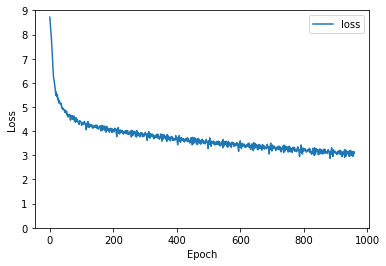

In [23]:
fig, ax2 = fig, ax = plt.subplots()

ax2.plot(loss_list,label='loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((0,9))

leg2 = ax2.legend();

In [22]:
val_saver.restore(val_sess, ckpt_path)

num_steps_val = n_batches_test
epo_loss_val = 0
txt = open(output_filename, 'w')
for j in range(0,n_batches_test):
    data_batch_val = np.array(vid_batch_test[i])
    label_batch_val = np.array(intencode_batch_test[i])
    id_batch_val = id_batch_test[i]
    caption_lens_batch_val = np.array(cap_len_batch_test[i])

    loss_val, p_val, summ = val_sess.run([loss_op_val, dec_pred_val, summary_val], 
                                feed_dict={feat_val: data_batch_val,
                                           captions_val: label_batch_val,
                                           cap_len_val: caption_lens_batch_val})

    seq_val = pred_print(p_val, caption_lens_batch, label_batch_val, index2token, batch_size_test, id_batch_val)
    total_loss_val += loss_val

    for k in range(0, batch_size_test):
            txt.write(id_batch_val[k] + "," + seq_val[k] + "\n")

print('\nSave file: ' + output_filename)
txt.close()
call(['python3', 'MLDS_hw2_1_data/bleu_eval.py', output_filename])

print("Validation: " + str((j+1) * batch_size_test) + "/" + \
        str(n_batches_test) + ", done..." \
        + "Total Loss: " + "{:.4f}".format(total_loss_val))

INFO:tensorflow:Restoring parameters from saved_model/trained_model.ckpt-959


KeyError: 95

In [ ]:
seq = pred_print(p, caption_lens_batch, label_batch, index2token, batch_size, id_batch_train)


In [ ]:
np.random.randint(batch_size,10)


In [ ]:
# model = Video_Caption_Generator(dim_image=n_features, 
#                                 n_words = n_words, 
#                                 dim_hidden = n_hidden, 
#                                 batch_size=batch_size, 
#                                 n_lstm_steps=80,
#                                 n_video_lstm_step=80,
#                                 n_caption_lstm_step=80,
#                                 bias_init_vector=bias_init_vector)

In [ ]:
# tf_loss, tf_video, tf_video_mask, tf_caption, tf_caption_mask, tf_probs = model.build_model()


In [ ]:
# n_words = n_words

# with tf.Graph().as_default() as graph:
    

#     weights_enc = tf.Variable(tf.random_uniform([n_features, n_hidden],-0.1,0.1),name="weights_enc")
#     bias_enc = tf.Variable(tf.zeros([n_hidden]),name="bias_enc")

#     weights_dec = tf.Variable(tf.random_uniform([n_hidden, n_words],-0.1,0.1),name="weights_dec")
#     bias_dec = tf.Variable(tf.zeros([n_words]),name="bias_dec")


#     x_video = tf.placeholder(tf.float32, (None, no_of_frames, n_features),'video_features') #inputs

#     batch_size = tf.shape(x_video)[0]
    
#     x_video_drop = tf.nn.dropout(x_video, 0.5)
    
#     x_video_flat = tf.reshape(x_video_drop,[-1,n_features])

#     y_label = tf.placeholder(tf.int32,(None, sizeof_sentence),'captions') #outputs


#     #sampling = tf.placeholder(tf.bool, [sizeof_sentence], name='sampling')
#     padding = tf.zeros([batch_size, n_hidden])

#     loss = 0.0

#     ########## DATA ###########
#     # Example: For i = 0
#     #batch_x = np.array(vid_batch[0])
#     #batch_y = np.array(intencode_batch[0])
#     ###########################

#     input_embedding = tf.matmul(x_video_flat,weights_enc) + bias_enc
#     input_embedding = tf.reshape(input_embedding,[-1, no_of_frames,n_hidden])
#     input_embed = tf.transpose(input_embedding, perm=[1, 0, 2])

#     with tf.device("/cpu:0"):
#         output_embedding = tf.Variable(tf.random_uniform((n_words, n_hidden),-0.1,0.1), name='dec_embedding')
#     # output_embed = tf.nn.embedding_lookup(output_embedding,y_label)
    
#     ## ENCODING #################################
    
#     with tf.variable_scope("LSTM1"):
#         lstm1 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden,state_is_tuple=True)
#         lstm1 = tf.contrib.rnn.DropoutWrapper(lstm1, output_keep_prob=0.5)    

#     with tf.variable_scope("LSTM2"):
#         lstm2 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, state_is_tuple=True)
#         lstm2 = tf.contrib.rnn.DropoutWrapper(lstm2, output_keep_prob=0.5)    


#     state1 = lstm1.zero_state(batch_size, dtype=tf.float32)
#     state2 = lstm2.zero_state(batch_size, dtype=tf.float32)
    
#     for i in range(0, no_of_frames):
        
#         if i > 0:
#                 tf.get_variable_scope().reuse_variables()
                
#         with tf.variable_scope("LSTM1"):
#             output1, state1 = lstm1(input_embed[i,:,:], state1)

#         with tf.variable_scope("LSTM2"):
#             output2, state2 = lstm2(tf.concat([padding, output1], axis=1), state2)
    
#     ## DECODING ##################################
    
#     bos = tf.ones([batch_size, n_hidden])
#     padding_in = tf.zeros([batch_size, n_hidden])

#     logits = []
#     cross_ent_list=[]
#     max_prob_index = None


#     for i in range(0, MAX_WORDS):
        
#         tf.get_variable_scope().reuse_variables()

        
#         with tf.variable_scope("LSTM1"):
#             output1, state1 = lstm1(padding_in, state1)
            
#         if i == 0:
            
#             with tf.variable_scope("LSTM2"):
#                 con = tf.concat([bos, output1], axis=1)
#                 output2, state2 = lstm2(con, state2)
                
#         else:
            
#             with tf.device("/cpu:0"):
            
#                 feed_in = y_label[:,i]
#                 #feed_in = tf.argmax()
#                 output_embed = tf.nn.embedding_lookup(output_embedding,feed_in)
                
#             with tf.variable_scope("LSTM2"):
#                 con = tf.concat([output_embed, output1], axis=1)
#                 output2, state2 = lstm2(con, state2)

#         logit_words = tf.matmul(output2, weights_dec) + bias_dec
#         logits.append(logit_words)

#         word_i = y_label[:,i]

#         one_hot_labels = tf.one_hot(word_i, n_words, on_value = 1, off_value = None, axis = 1) 
#         cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words, labels=one_hot_labels)
#         cross_ent_list.append(cross_entropy)
        
        
#         #current_loss = tf.reduce_sum(cross_entropy)/batch_size
#         #loss = loss + current_loss

#     cross_entropy_tensor = tf.stack(cross_ent_list, 1)
#     loss = tf.reduce_sum(cross_entropy_tensor, axis=1)
#     loss = tf.divide(loss, tf.cast(tf.Variable(sizeof_sentence), tf.float32))

#     loss = tf.reduce_mean(loss, axis=0)
    
#     summary = tf.summary.scalar('training_loss', loss)

#     params = tf.trainable_variables()
#     #optimizer = tf.train.AdamOptimizer(learning_rate)#.minimize(loss_op)
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#     train_op = optimizer.minimize(loss)

#     #train_step = optimizer.minimize(loss)
    
# #     gradients, variables = zip(*optimizer.compute_gradients(loss))
# #     gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
# #     train_op = optimizer.apply_gradients(zip(gradients, params))
    
# #     logits = tf.stack(logits, axis = 0)
# #     logits = tf.reshape(logits, (sizeof_sentence, batch_size, n_words))
# #     logits = tf.transpose(logits, [1, 0, 2])
# #     preds = tf.argmax(logits,2)
# #     correct_pred = tf.equal(tf.argmax(preds,1), tf.argmax(y_label,1))
# #     accuracy = tf.reduce_mean(correct_pred)

#     logits = tf.stack(logits,axis=0)
#     logits = tf.transpose(logits, [1, 0, 2])
#     output_preds = tf.argmax(logits,2)
    
#     #correct_pred = tf.equal(tf.argmax(output_preds, 1), tf.argmax(y_label, 1))
#     #accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
#     saver = tf.train.Saver(max_to_keep=3)


In [ ]:
# loss

In [ ]:
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

# gpu_config = tf.ConfigProto()

# with tf.Session(graph=graph,config=gpu_config) as sess:

#     loss_list_train = []
#     loss_list_test = []
#     preds_dict = {}

#     sess.run(tf.global_variables_initializer())
#     epochs = 10

#     #training
#     n=0

#     for epoch in range(epochs):

#         for i in range(n_batches):

#             batch_x = np.array(vid_batch[i])
#             #batch_x = np.reshape(batch_x,[-1,n_features])
#             batch_y = np.array(intencode_batch[i])

#             _, batch_loss, preds = sess.run([train_op, loss, logits], feed_dict = {x_video: batch_x, y_label: batch_y})        

#             loss_list_train.append(batch_loss)
#             print("train: %f " % (batch_loss))

            
#             n = n+1

       
#     #testing
    
#         saver.save(sess,ckpt_path, global_step=n)
#         print('Model saved at ' + ckpt_path)
        
    
#     for i in range(n_batches_test):

#         batch_x_test = np.array(vid_batch_test[i])
#         #batch_x = np.reshape(batch_x,[-1,n_features])
#         batch_y_test = np.array(intencode_batch_test[i])

#         acc = sess.run(accuracy, feed_dict = {x_video: batch_x_test, y_label: batch_y_test})        
#         print("accuracy %f" % acc)

# #         loss_list_test.append(batch_loss)
# #         print("test:", batch_loss)
    
# #         preds_dict[i] = batch_preds 

In [ ]:
# with tf.variable_scope("encoding") as encoding_scope:
#     lstm_enc = tf.contrib.rnn.BasicLSTMCell(n_hidden)
#     _, last_state = tf.nn.dynamic_rnn(lstm_enc, inputs=input_embed, dtype=tf.float32)

In [ ]:
# with tf.variable_scope("decoding") as decoding_scope:
#     # TODO: create the decoder LSTMs, this is very similar to the above
#     # you will need to set initial_state=last_state from the encoder
#     lstm_dec = tf.contrib.rnn.BasicLSTMCell(n_hidden)
#     dec_outputs, _ = tf.nn.dynamic_rnn(lstm_dec,inputs=output_embed, dtype=tf.float32)

In [ ]:
# #connect outputs to 
# logits = tf.contrib.layers.fully_connected(dec_outputs, num_outputs=len(index2token), activation_fn=None) 

# with tf.name_scope("optimization"):
#     # Loss function
#     loss = tf.contrib.seq2seq.sequence_loss(logits, targets, tf.ones([batch_size, sizeof_sentence]))
#     # Optimizer
#     optimizer = tf.train.RMSPropOptimizer(1e-3).minimize(loss)

In [ ]:
# output_dec.get_shape().as_list()

In [ ]:
# state_dec[0].get_shape().as_list()

In [ ]:
# x_video.get_shape().as_list()

In [ ]:
# from utilities import show_graph
# show_graph(tf.get_default_graph().as_graph_def())

In [ ]:
# def RNN(x, weights1, biases1):
    
#     x = tf.unstack(x,no_of_frames,1)
    
#     lstm_encoder = tf.keras.layers.LSTM(n_hidden, return_state=True) #reuse=tf.AUTO_REUSE)
#     output_encoder,state_h,state_c = lstm_encoder(x) #,dtype=tf.float32)
#     encoder_states = [state_h,state_c]
    
#     decoder
    
#     return tf.matmul(output1[-1],weights1) + bias1

In [ ]:
# np.shape(vid_batch[1])

In [ ]:
# logits = RNN(x_video,weights1,bias1)
# prediction = tf.nn.softmax(logits)


# loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_label))


# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
# train_op = optimizer.minimize(loss_op)

# # Evaluate model (with test logits, for dropout to be disabled)
# correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_label, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
# batch_y = np.array(intencode_batch[1])
# np.shape(batch_y)

In [ ]:
# batch_x = np.array(vid_batch[0])
# print(np.shape(batch_x))
# batch_x = np.reshape(batch_x,[-1,n_features])
# np.shape(batch_x)

In [ ]:
# preds_dict[0]
# def predicted_sentence(preds_dict):
    

In [ ]:
# batch_x = np.array(vid_batch[0])
# batch_y = np.array(intencode_batch[0])

# with tf.Session() as sess:
#     sess.run(init)

#     sess.run(train_op, feed_dict={x_video: batch_x, y_label: batch_y})

In [ ]:


# image_emb = tf.nn.xw_plus_b(x_video, weights1, bias1) 
# #image_emb = tf.reshape(image_emb, [batch_size, no_of_frames, n_hidden])

# #lstm2 = tf.keras.layers.LSTMCell(n_hidden)

# padding = tf.zeros([batch_size, n_hidden])


# #Only read the frames


        

            
                
# logit_words = tf.nn.xw_plus_b(output2, weights2, bias2)
# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logit_words,onehot_encoded)

# loss = tf.reduce_sum(cross_entropy)

In [ ]:
# with tf.Session() as sess:
#     with sess.as_default():
#         print(tf.nn.embedding_lookup(onehot_encoded,[1]).eval())

In [ ]:
# inputs